*This notebook must be run using the capstone environment*

# <center> Modeling, Optimisation and Evaluation


---


## Contents

### 1. Introduction: Overview of Modelling Thought Process
&nbsp;
### 2. Logistic Regression Classifier 
- ADASYN sampling
- SMOTE sampling
- RandomOver sampling
- RandomUnder sampling
- Summary

&nbsp;

### 3. Decision Tree Classifier
- RandomOver sampling
- RandomUnder sampling
- Summary

&nbsp;

### 4. Random Forest Classifier
- RandomOver sampling
- RandomUnder sampling
- Summary

&nbsp;

### 5. Closing Statement and Further Steps


---

## 1. Overview of Considerations Prior to Model Creation

The main concern with my dataset is imbalance, to address this i'll be employing a range of sampling techniques. 

- Downsampling: Aims to reduce the majority class to that of the minority. This method inherently comes with the price of losing some data and has some notable disadvantages. Firstly, reducing the number of samples in the majority class results in a loss of information that can compromise the representatation of the majority class. This can hinder the model's ability to learn from the majority class and ultimately lead to reduced performance. Secondly, this method of sampling can exacerbate problems with difficult-to-learn minority class examples.

- Random Upsampling: Upsampling involves increasing the number of samples in the minority class to match the number of samples in the majority class. Random upsampling risks overfitting data as duplicates of already existing data are being created. I dont think this is going to be an issue with my dataset and could actually aid performance. The dataset is very imbalanced, but not very complex. As such the I think there will be very few cases of 'hard-to-learn' minority class examples. With this being the case, random oversampling could help amplify the few patterns that do exist and make them more discernable from the noise in the majorty class. This is pure speculation, but could be an interesting case. 

- SMOTE (Synthetic Minority Over-sampling Technique): Creates synthetic data points for the minority class by identifying the nearest neighbors of existing minority samples, then creating new samples by interpolating between the minority sample and its neighbors. SMOTE has a notable advantage over other sampling techniques, it increases the size of the minority sample without increasing the chances of overfitting. 

- ADASYN (Adaptive Synthetic Sampling): A variant of SMOTE designed to address its limitations, it is quite computationally expensive as it generates its synthetic data points using the KNN algorithm. Some advantages of ADASYN over other techniques include: 
    1. It adapts to the underlying distribution of the minority class, which can improve the quality of the synthetic samples generated.

    2. It generates more synthetic samples for difficult-to-learn minority class examples, while generating fewer synthetic samples for easy-to-learn minority class examples.

    3. It is less susceptible to overfitting and can generalise better to unseen data.
    
https://medium.com/quantyca/oversampling-and-undersampling-adasyn-vs-enn-60828a58db39


This notebook aims to create optimised logistic regression, DT and ensemble models that predict the chance of cardiovasular disease. 
I'm placing a high importance on the interpretability of the models I create. As such, im going to exclude SVM and KNN models. If logistic regression/DT methods yield poor results, i'll employ SVM/KNN and use recursive feature elimination to extract feature importance.

I'll employ GridSearchCV with 5 fold cross validation to optimise the models. The baseline model highlighted a poor performance in the recall and precision scores. With this in mind, im going to refit models using F1 score. 


In [108]:
# Data Manipulation
import numpy as np
import pandas as pd
import joblib

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Optimisation
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV


# Evaluation
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_curve, roc_auc_score, \
    classification_report, accuracy_score, precision_recall_curve
from sklearn.metrics import make_scorer
# Sampling
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings("ignore")


In [109]:
# Loading in the cleaned dataset.
df = pd.read_csv("~/Desktop/BrainStation_Bootcamp/Capstone/capstone-project-ollieleach95/src/data/Lifestyle_heart_data_clean.csv")
df

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,...,Race_Hispanic,Race_Other,Race_White,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy)
0,0,16.60,1,0,0,3,30,0,0,57,...,0,0,1,0,0,0,1,0,1,0
1,0,20.34,0,0,1,0,0,0,0,80,...,0,0,1,0,0,0,1,0,0,0
2,0,26.58,1,0,0,20,30,0,1,67,...,0,0,1,1,0,0,0,0,1,0
3,0,24.21,0,0,0,0,0,0,0,77,...,0,0,1,0,1,0,0,0,0,0
4,0,23.71,0,0,0,28,0,1,0,42,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299374,1,27.41,1,0,0,7,0,1,1,62,...,1,0,0,1,0,0,0,0,1,0
299375,0,29.84,1,0,0,0,0,0,1,37,...,1,0,0,0,0,0,1,0,0,0
299376,0,24.24,0,0,0,0,0,0,0,47,...,1,0,0,0,1,0,0,0,0,0
299377,0,32.81,0,0,0,0,0,0,0,27,...,1,0,0,0,1,0,0,0,0,0


In [110]:
# Assigning X and y
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (299379, 26)
y shape: (299379,)


In [111]:
# Train test split prior to performing any upsampling. 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y, test_size=0.25)

In [112]:
# Sanity check that the upsampling is working.
# I also want to check how long it takes to run each upsample and the final balance in the datasets following upsampling. 
# These datasets will not be carried forward to a GridSearchCV.

# Upsampling
X_train_smote, y_train_smote = SMOTE(random_state=1).fit_resample(X_train, y_train)
X_train_adasyn, y_train_adasyn = ADASYN(random_state=1).fit_resample(X_train, y_train)
X_train_randup, y_train_randup = RandomOverSampler(random_state=1).fit_resample(X_train, y_train)
X_train_randund, y_train_randund = RandomUnderSampler(random_state=1).fit_resample(X_train, y_train)

# Sanity checks
print(y_train_smote.value_counts())
print(y_train_adasyn.value_counts())
print(y_train_randup.value_counts())



HeartDisease
0    204355
1    204355
Name: count, dtype: int64
HeartDisease
0    204355
1    203182
Name: count, dtype: int64
HeartDisease
0    204355
1    204355
Name: count, dtype: int64


This has worked, ADASYN sampling_strategy was set to the default value of 'auto'. This aims to balance the classes by automatically computing the ratio of samples in the input classes. The resulting ratio in the output classes will vary depending on the specific distribution of samples in the input classes.
As our original dataset has a large class imbalance, setting sampling_strategy='auto' results in an output dataset that is still imbalanced, but far less so than the original.

## 2. Logistic Regression

Prior to creation of the GridSearch I want to outline my thought process for deciding on gridsearch hyperparameters.

Im going to use the first round of Gridsearch (logistic regression v1) to gauge the time taken to run the gridsearches, if its taking ages i'll move to a RandomSearchCV.

Scalers: 
- RobustScaler: Im going to omit the Robust scaler, this is optimised towards datasets with many outliers 

- MinMaxScaler: I think this is worth trying, most of the data is in a binary format, as such, most of our data is already in its 'post scaled form'. In addition to this, documentation states that this scaler is suited towards datasets that arent normally distributed. One thing to note, MinMaxScaler is sensitive to outliers, since the scaling is based on the minimum and maximum values in the dataset. I dont think I have to worry about this, there are some outliers in the BMI feature, but no other features contain outliers.

- StandardScaler: This scaler scales the data to have a mean of 0 and a standard deviation of 1. Documentation indicates this is a good choice when the distribution of the data is normal. I dont think this scaler is optimised towards my data, but I'll include it as a proof of my hypothesis for the first round of Gridsearches.

- MaxAbsScaler: MaxAbsScaler scales the data so that the absolute maximum value of each feature is 1. This means that the range of the data may be different for each feature, but all values will be between -1 and 1. MaxAbsScaler is less sensitive to outliers than MinMaxScaler, since it only considers the absolute values of the data (this advantage is negligible in my case). I'll include this in the Gridsearch too. 

C values:

- I'll use a large range of C values, the second round of Gridsearch will reduce the range.

Penalties:

- I'll employ both L1 and L2 penalties. As im curious, i'll include ElasticNet too. 

Solvers:

- Im not entirely sure how to decide on these. From reading it seems that the main difference between solvers lies in their ability to handle larger datasets. As my dataset isnt overly large, I think just using the default solver of lbfgs would suffice. However, lbfgs does not support L1 regularisation. With this in mind, im going to include a solver that supports elasticnet, one solver that supports L1 regularisation and one solver that supports L2 regularisation. Saga, liblinear, lbfgs.


PCA:

- I dont think it will be sensible to employ PCA in this project. I need to retain as much interpretability in my model as possible given the need to advice users on their lifestyle improvements in my final app. 
As I don't have a lot of features in the dataset, the model isnt overly complex and the value gained from PCA will be minimal. In addition to this, PCA will reduce interpretability due to it transforming my original features into combinations of features.


Regularisation:

- We saw from my baseline model that a couple features were statistically insignificant. As such, using regularisation will be important to help remove these redundant features. 
Its important to note that regularisation may not remove features that are highly collinear. I shouldnt have to worry about this too much, I found that none of my features were over the threshold for collinearity during my baseline model EDA. 

As a final note, I want to fit the model based on F1 score. As such, I need to make scorers.

In [113]:
# Creating the scoring metrics to pass to my Gridsearch scoring parameter. 
# This will allow me to choose which method of scoring by calling the keys from my scoring dictionary in the refit parameter.
f1_made = make_scorer(f1_score)
precision_made = make_scorer(precision_score)
recall_made = make_scorer(recall_score)
accuracy_made = make_scorer(accuracy_score)

####  Test GridSearchCV

Im going to test the dictionary parameters in the scoring parameter prior to committing to a full scale gridsearch.

In [114]:
# Define pipeline with SMOTE sampling, MinMaxScaler, and Logistic Regression model
estimators_test_run = [
    ('sampling', SMOTE(random_state=1)),
    ('scaler', MinMaxScaler()),
    ('model', LogisticRegression(solver='lbfgs', random_state=1))
]

pipeline_test = imbPipeline(estimators_test_run)

# Define grid search parameters for C parameter in Logistic Regression
params_test_run = [{'model__C': [.00001]}]

# Perform grid search with 5-fold cross validation, using F1 score as metric for refit
grid_test_run = GridSearchCV(pipeline_test, param_grid=params_test_run, cv=5, 
                             n_jobs=-1, 
                             scoring={'f1': f1_made, 'recall': recall_made, 
                                      'precision': precision_made, 'accuracy': accuracy_made}, 
                             refit='f1', verbose=1)

# Fit grid search to training data and score on test data using F1 score
grid_test_run.fit(X_train, y_train)
test_score_v1_smote = grid_test_run.score(X_test, y_test)

# Print test F1 score for model with SMOTE sampling
print("Test F1 score SMOTE Data: ", test_score_v1_smote)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Test F1 score SMOTE Data:  0.3023143683702989


In [115]:
print("Test F1 score SMOTE Data: ", test_score_v1_smote)

Test F1 score SMOTE Data:  0.3023143683702989


This has worked, lets commit to a full gridsearch and begin with our ADASYN scaled data.

### ADASYN GridSearchCV:

#### Version 1:

In [116]:
# c_values = [.0001, .001, .1, 1, 10, 100]
# estimators_v1_adasyn = [
# ('sampling', ADASYN(random_state=1)),
#     ('scaler', StandardScaler()),
#     ('log_model', LogisticRegression(random_state=1))
#     ]

# pipe_v1_adasyn = imbPipeline(estimators_v1_adasyn)

# # Creating our parameters to feed our GridSearchCV
# params_v1_adasyn = [    

#     # l1 with PCA, solver liblinear
#     {'scaler': [MaxAbsScaler(), MinMaxScaler()],
#      'log_model': [LogisticRegression(solver='liblinear',penalty='l1', random_state=1, n_jobs=-1, max_iter=10000)],
#      'log_model__C': c_values},

#     # l2 with PCA, solver lbfgs
#     {'scaler': [MaxAbsScaler(), MinMaxScaler()],
#      'log_model': [LogisticRegression(solver='lbfgs' ,penalty='l2', random_state=1, n_jobs=-1, max_iter=10000)],
#      'log_model__C': c_values},

#     # elastic with PCA, solver saga
#     {'scaler': [MaxAbsScaler(), MinMaxScaler()],
#      'log_model': [LogisticRegression(solver = 'saga',penalty='elasticnet', random_state=1, n_jobs=-1, max_iter=10000, l1_ratio=0.5)],
#      'log_model__C': c_values}]

# grid_v1_adasyn = GridSearchCV(pipe_v1_adasyn, param_grid=params_v1_adasyn, cv=5, \
#                                    n_jobs=-1, scoring={'f1': f1_made, 'recall': recall_made, 
#                                                        'precision':precision_made, 'accuracy': accuracy_made}, refit='f1', verbose=1)

# fittedgrid_V1_adasyn = grid_v1_adasyn.fit(X_train, y_train)


# # Print the best hyperparameters and corresponding mean score for the train dataset
# print("Best parameters: ", fittedgrid_V1_adasyn.best_params_)
# print("Best F1 train score: ", fittedgrid_V1_adasyn.best_score_)

# test_f1_score_v1_adasyn = grid_v1_adasyn.score(X_test, y_test)

# print("Test F1 score ADASYN data: ", test_f1_score_v1_adasyn)
# joblib.dump(fittedgrid_V1_adasyn, '../models/log_reg_models/adasyn_logit_version1.pkl')

Some context on the previous section of code.

I ran this gridsearch prior to consideration of creating a function that can be used for all sampler types. This model took 1400minutes to run so im unwilling to rerun it once a function is created.

During this first iteration of constructing the Gridsearch, I placed the solver/penalty inside the `LogisticRegression()` method. As such, when calling `.best_params_` the sovler/penalty was excluded. Im going to create a function and edit the code of the gridsearch ensuring that the solvers/penalties are correctly inputed as parameters outside of the Logreg methods.

Due to this mistake, I need to manually extract the solver/penalty as there doesnt appear to be attribute in the sk.learn documentation for this.

To do this I need to extract how many combinations ran in my gridsearch and then find the index of the best model.


In [117]:
# Loading the fitted model
adasyn_logit_version1 = joblib.load('../models/log_reg_models/adasyn_logit_version1.pkl')

In [118]:
# Extracting the best parameters to show it is excluding the solver and penalty.
adasyn_logit_version1.best_params_

{'log_model': LogisticRegression(C=0.0001, max_iter=10000, n_jobs=-1, random_state=1),
 'log_model__C': 0.0001,
 'scaler': MinMaxScaler()}

In [119]:
# Sanity checking the number of combinations.
len(adasyn_logit_version1.cv_results_['mean_fit_time'])

36

There were 36 cominations in my parameter grid, there are three different logistic regression models being fitted in the gridsearch, therefore, we have 12 combinations per model. 

In [120]:
# Finding the index of the best model
adasyn_logit_version1.best_index_

13

The index of the best model is 13 this means the best model used the lbfgs solver and L2 penalty.
Now we have this information I can extract all score metrics I need for a version two of the model. For now, lets perform analysis on  the v1 model. 

#### Analysis considerations: 

In evaluating the Version 1 models, I'll employ precision, recall, F1 and accuracy scores, as well as generate a confusion matrix to provide a visual representation of the model's performance across different types of cases.

For the final version of my models, I'll include ROC curve analysis, precision-recall curve analysis and feature importance.


In [121]:
# A function to evaluate the model

def model_eval(X_train, y_train, X_test, y_test, model):
    '''
    Evaluate a machine learning model using various performance metrics.
    
    Parameters:
    -----------
    X_train (pandas.DataFrame):  The input training data.
    y_train (pandas.DataFrame):  The target training data.
    X_test (pandas.DataFrame): Test set features
    y_test (pandas.DataFrame): Test set target variable
    model: Fitted ML model
        
    Returns:
    Confusion matrix, F1, Recall and precision scores for both train and test data. 
    '''
    
    # Getting the model predictions from X_test
    y_predicted = model.predict(X_test)

    # confusion matrix
    sns.set(rc={'figure.figsize':(6,4)})
    cmatrix = confusion_matrix(y_test, y_predicted)
    print(cmatrix)
    sns.heatmap(cmatrix, annot=True, cmap='Reds')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

    # Classification report of true Y values vs predicted
    print(classification_report(y_test, y_predicted))

    print(f'F1 score: {model.score(X_test, y_test)*100:0.1f}%')
    print(f'Recall score: {recall_score(y_test, y_predicted)*100:0.1f}%')
    print(f'Precision score: {precision_score(y_test, y_predicted)*100:0.1f}%')
    print(f'Train Accuracy score: {accuracy_score(y_train, model.predict(X_train))*100:0.1f}%')
    print(f'Test Accuracy score: {accuracy_score(y_test, y_predicted)*100:0.1f}%')
    print(f'The Parameters of this model are {model.best_params_}')

[[49471 18648]
 [ 2369  4357]]


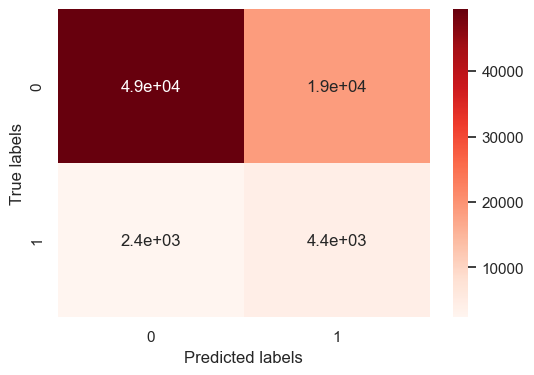

              precision    recall  f1-score   support

           0       0.95      0.73      0.82     68119
           1       0.19      0.65      0.29      6726

    accuracy                           0.72     74845
   macro avg       0.57      0.69      0.56     74845
weighted avg       0.89      0.72      0.78     74845

F1 score: 29.3%
Recall score: 64.8%
Precision score: 18.9%
Train Accuracy score: 71.8%
Test Accuracy score: 71.9%
The Parameters of this model are {'log_model': LogisticRegression(C=0.0001, max_iter=10000, n_jobs=-1, random_state=1), 'log_model__C': 0.0001, 'scaler': MinMaxScaler()}


In [122]:
# Calling our function on the version 1 model
model_eval(X_train, y_train, X_test, y_test, adasyn_logit_version1)

### ADASYN Model Version 1 Evaluation:

#### Confusion Matrix Analysis: A quick refresher.

- The top-left cell represents the number of true negatives (TN), which is the number of samples that are actually negative and were correctly predicted to be negative. In this case, the value is 49471.

- The top-right cell represents the number of false positives (FP), which is the number of samples that are actually negative but were incorrectly predicted to be positive. In this case, the value is 18648.

- The bottom-left cell represents the number of false negatives (FN), which is the number of samples that are actually positive but were incorrectly predicted to be negative. In this case, the value is 2369.

- The bottom-right cell represents the number of true positives (TP), which is the number of samples that are actually positive and were correctly predicted to be positive. In this case, the value is 4357.

The  model is fairly well adapted to predicting the negative class, but is struggling to predict the postive class. The precision with respect to the negaitive class is 95%, meaning that when a negative class is predicted the model is correct 96% of the time. This is in contrast to the 19% precision the model has when predicting the positive class. 
The recall for both negative and positive classes is fairly similar at 73%/65% respectively. 


#### Score Metrics Analysis: 

As a reminder, my baseline model results are as follows:

- Accuracy Score: 91.2%
- Recall Score: 10.4%
- Precision Score: 54.3%

Total time for this gridsearch was 400minutes.. Optimisation of a logistic regression model on ADASYN upsampled data has resulted in a ~55% improvement to recall score. This has come at a price, in order to capture more positive cases of CVD, my model accuracy has reduced by ~20% and precision has reduced by ~35%. In improving recall score, the number of false positives has also drastically increased. 
The train and test accuracy scores are very close together indicating negligible overfitting. 

I'm going to stop the ADASYN disussion here and instead wait to see the results of other sampling methods. Given the amount of time required to run this model, im nervous to perform any iterations. If the other sampling techniques return very low quality models, i'll entertain the idea of iterating on an ADASYN model. 

---

### SMOTE GridSearchCV:

#### Version 1:

In [123]:
# Assignign a wide range of parameter values 
c_values = [.0001, .001, .1, 1, 10, 100]

In [124]:
# Creating a logistic regression function that allows for the use of different sampler
def GridSearch_logit_v1(sampler, X_train, y_train, X_test, y_test, model_name, c_values, path='', suffix = '_logit_version1.pkl'):

    """
    Fits a logistic regression model using GridSearchCV with different combinations of hyperparameters.
    Allows for the use of different samplers.

    Args:
    sampler (object): Sampling method from imblearn library to be used to balance the dataset.
    X_train (pandas.DataFrame):  The input training data.
    y_train (pandas.DataFrame):  The target training data.
    X_test (pandas.DataFrame): Test set features
    y_test (pandas.DataFrame): Test set target variable
    model_name (str): The name of the model.
    c_values (array or list): The values of the inverse regularisation strength to be used for the logistic regression model.
    path (str): The file path to save the model. Default is ''.
    suffix (str): The suffix to add to the model file name. Default is '_logit_version1.pkl'.

    Returns:
    model.pkl file
    """
    
    f1_made = make_scorer(f1_score)
    precision_made = make_scorer(precision_score)
    recall_made = make_scorer(recall_score)
    accuracy_made = make_scorer(accuracy_score)

    estimators_v1_model = [
        ('sampling', sampler(random_state=1)),
        ('scaler', StandardScaler()),
        ('log_model', LogisticRegression(random_state=1))
        ]

    pipe_v1_model = imbPipeline(estimators_v1_model)

    # Creating our parameters to feed our GridSearchCV
    params_v1_model = [    

    # l1 with PCA, solver liblinear
    {'scaler': [MaxAbsScaler(), MinMaxScaler()],
     'log_model': [LogisticRegression(random_state=1, n_jobs=-1, max_iter=10000)],
     'log_model__solver': ['liblinear'],
     'log_model__penalty': ['l1'],
     'log_model__C': c_values},

    # l2 with PCA, solver lbfgs
    {'scaler': [MaxAbsScaler(), MinMaxScaler()],
     'log_model': [LogisticRegression(random_state=1, n_jobs=-1, max_iter=10000)],
     'log_model__solver': ['lbfgs'],
     'log_model__penalty': ['l2'],
     'log_model__C': c_values},

    # elastic with PCA, solver saga
    {'scaler': [MaxAbsScaler(), MinMaxScaler()],
     'log_model': [LogisticRegression(random_state=1, n_jobs=-1, max_iter=10000, l1_ratio=0.5)],
     'log_model__solver': ['saga'],
     'log_model__penalty': ['elasticnet'],
     'log_model__C': c_values}]

    grid_v1_model = GridSearchCV(pipe_v1_model, param_grid=params_v1_model, cv=5, \
                                   n_jobs=-1, scoring={'f1': f1_made, 'recall': recall_made, 
                                                       'precision':precision_made, 'accuracy': accuracy_made}, refit='f1', verbose=1)

    fittedgrid_V1_model = grid_v1_model.fit(X_train, y_train)


    # Print the best hyperparameters and corresponding mean score for the train dataset
    print("Best parameters: ", fittedgrid_V1_model.best_params_)
    print("Best F1 train score: ", fittedgrid_V1_model.best_score_)

    test_f1_score_v1 = fittedgrid_V1_model.score(X_test, y_test)

    print("Test F1 score: ", test_f1_score_v1)
    
    return joblib.dump(fittedgrid_V1_model, f'{path}{model_name}{suffix}')



In [125]:
# # Creating a SMOTE logit model.
# GridSearch_logit_v1(SMOTE, X_train, y_train, X_test, y_test, 'smote', c_values, '../models/log_reg_models/')

Im going to comment out all models that have run in this notebook, uncommenting them can be done at the discression of the viewer. Most models took ~15 minutes to run, some took ~400 minutes.

In [126]:
# Loading the fitted model
smote_logit_model_v1 = joblib.load('../models/log_reg_models/smote_logit_version1.pkl')

#### Model Evaluation:

[[49871 18248]
 [ 2305  4421]]


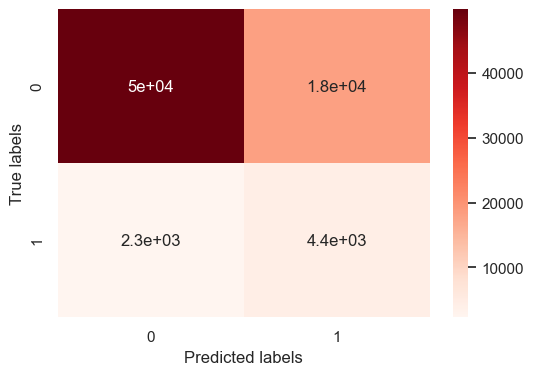

              precision    recall  f1-score   support

           0       0.96      0.73      0.83     68119
           1       0.20      0.66      0.30      6726

    accuracy                           0.73     74845
   macro avg       0.58      0.69      0.56     74845
weighted avg       0.89      0.73      0.78     74845

F1 score: 30.1%
Recall score: 65.7%
Precision score: 19.5%
Train Accuracy score: 72.4%
Test Accuracy score: 72.5%
The Parameters of this model are {'log_model': LogisticRegression(C=0.0001, max_iter=10000, n_jobs=-1, random_state=1), 'log_model__C': 0.0001, 'log_model__penalty': 'l2', 'log_model__solver': 'lbfgs', 'scaler': MinMaxScaler()}


In [127]:
# Calling model evaluation function
model_eval(X_train, y_train, X_test, y_test, smote_logit_model_v1)

#### Score analysis:

Baseline/Adasyn model results are as follows:

Baseline:

- Accuracy Score: 91.2%
- Recall Score: 10.4%
- Precision Score: 54.3%

Adasyn:

- F1 score: 29.3%
- Recall score: 64.8%
- Precision score: 18.9%
- Train Accuracy score: 71.8%
- Test Accuracy score: 71.9%

Smote v1:
- F1 score: 30.1%
- Recall score: 65.7%
- Precision score: 19.5%
- Train Accuracy score: 72.4%
- Test Accuracy score: 72.5%


The results of this model are a little better than the ADASYN model. Im slightly surprised by this, research indicated that the ADASYN sampling method would return the highest quality model. When reflecting, the benefits ADASYN sampling provides might be negligible to my dataset. 

The benefits of ADASYN over SMOTE include:

1. It adapts to the underlying distribution of the minority class, which can improve the quality of the synthetic samples generated.

2. It generates more synthetic samples for difficult-to-learn minority class examples, while generating fewer synthetic samples for easy-to-learn minority class examples.

3. It is less susceptible to overfitting and can generalise better to unseen data.

I'm surprised that all the combined benefits seem to be a detriment to model performance, perhaps ADASYN creates more noise in the data when upsampling.

The V1 model has achieved a train accuracy score of 72.4% and a test accuracy score of 72.5%. This suggests that the model is not overfitting and has generalised well on unseen data.
By optimising the model through the use of the SMOTE upsampled data, recall score has improved by approximately 55%. This improvement in recall indicates that the model is better at identifying true positive cases of CVD.

However, in order to achieve this improvement in recall, there was a trade-off in terms of accuracy and precision. The accuracy of the model decreased by approximately 20%, which means that the model is less reliable in making correct predictions overall. The precision score also decreased by approximately 35%, which indicates that the model is now predicting more false positives than before.

This increase in false positives is a direct consequence of the improvement in recall, as the model is now more sensitive in identifying positive cases of CVD. 


It appears that the optimal value for the C parameter lies at the lowermost limit of the range I specified. Im going to pass through some new c_values to the model in the lower range.

I'll hold off any ROC analysis until the final model. 

It's worth noting that the time taken to run this was only ~45 minutes, i'll continue to test SMOTE with other ML methods.

Finally, with the improvement model metrics compared to ADASYN, I'm going to drop ADASYN as a sampling option going forwards.


Actions for SMOTE version 2: 

- Provide a new range of c_values from 1x10-4 - 1x10-6.


### SMOTE Version 2:

I cant create a one size fits all function for version two models so i'll just write out the code.

In [128]:
# # Creating a new list of c values
# smote_v2_C_values = [0.0001, 0.00005, 0.00001, 0.000005, 0.000001]

# # Creating Pipeline
# estimators_v2_smote = [
#     ('sampling', SMOTE(random_state=1)),
#     ('scaler', MinMaxScaler()),
#     ('log_model', LogisticRegression(random_state=1))
# ]

# # Instantiating the pipeline
# pipe_v2_smote = imbPipeline(estimators_v2_smote)

# # Creating our parameters to feed our GridSearchCV
# params_v2_smote = [    

#     # l2 with PCA, solver lbfgs
#     {'log_model': [LogisticRegression(random_state=1, n_jobs=-1, max_iter=10000)],
#      'log_model__solver': ['lbfgs'],
#      'log_model__penalty': ['l2'],
#      'log_model__C': smote_v2_C_values}
#     ] 

# grid_v2_smote = GridSearchCV(pipe_v2_smote, param_grid=params_v2_smote, cv=5, \
#                                    n_jobs=-1, scoring={'f1': f1_made, 'recall': recall_made, 
#                                                        'precision':precision_made, 'accuracy': accuracy_made}, refit='f1', verbose=1)

# # Fitting the Gridsearch
# fittedgrid_v2_smote = grid_v2_smote.fit(X_train, y_train)


# # Print the best hyperparameters and corresponding mean score for the train dataset
# print("Best parameters: ", fittedgrid_v2_smote.best_params_)
# print("Best F1 train score: ", fittedgrid_v2_smote.best_score_)

# test_score_v2_smote = fittedgrid_v2_smote.score(X_test, y_test)
# print("Test F1 score SMOTE Data: ", test_score_v2_smote)

Again the code has been commented out, the model took ~80 minutes to run for version 2.

In [129]:
# # Saving the optimised model as a pkl
# joblib.dump(fittedgrid_v2_smote, '../models/log_reg_models/smote_logit_version2.pkl')

# Loading the pkl for analysis
smote_logit_model_v2 = joblib.load('../models/log_reg_models/smote_logit_version2.pkl')

### SMOTE version 2 Analysis:

[[50198 17921]
 [ 2337  4389]]


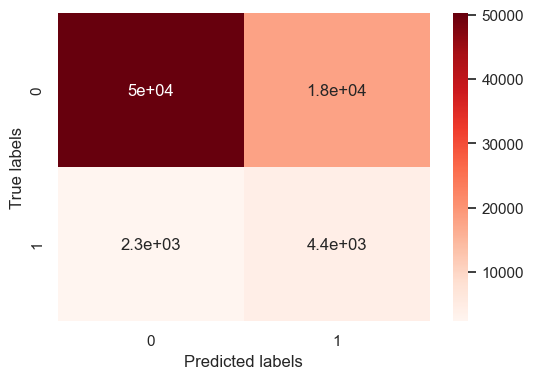

              precision    recall  f1-score   support

           0       0.96      0.74      0.83     68119
           1       0.20      0.65      0.30      6726

    accuracy                           0.73     74845
   macro avg       0.58      0.69      0.57     74845
weighted avg       0.89      0.73      0.78     74845

F1 score: 30.2%
Recall score: 65.3%
Precision score: 19.7%
Train Accuracy score: 73.0%
Test Accuracy score: 72.9%
The Parameters of this model are {'log_model': LogisticRegression(C=1e-05, max_iter=10000, n_jobs=-1, random_state=1), 'log_model__C': 1e-05, 'log_model__penalty': 'l2', 'log_model__solver': 'lbfgs'}


In [130]:
# Calling the model Evaluation function
model_eval(X_train, y_train, X_test, y_test, smote_logit_model_v2)

In [131]:
# Creating a function for our ROC (Receiver Operating Characteristic) Curve
def ROC_PR_Curve(X_test, y_test, model, model_name):
    
    """
    Create an ROC curve and Precision-Recall curve for a logistic regression model.
    
    Parameters:
    X_test (pandas.DataFrame): test set features
    y_test (pandas.DataFrame): test set target variable
    model: trained ML model
    model_name: str - name of the model to be used in the title of the plot
    
    Returns:
    Plots of the ROC curve and Precision-Recall curve
    """  
    

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    # ROC arrays
    fprs, tprs, threshholds = roc_curve(y_test, y_pred_proba)
    print("ROC AUC score:", roc_auc)

    # ROC plot
    sns.set(rc={'figure.figsize':(8, 6)})
    plt.figure()
    sns.lineplot(x=fprs, y=tprs, color='red', lw=2, label=f'ROC (AUC = {roc_auc:0.2f})')
    sns.lineplot(x=[0, 1], y=[0, 1], color='black', lw=2, label='random guess') # random guess
    plt.xlabel('FPR')
    plt.ylabel('Recall or TPR')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='best')
    plt.show()

    # Calculate precision-recall curve values
    precision, recall, PRthresholds = precision_recall_curve(y_test, y_pred_proba)

    # Precision Recall Plot
    plt.figure()
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {model_name}')
    plt.show()

ROC AUC score: 0.7620737573181444


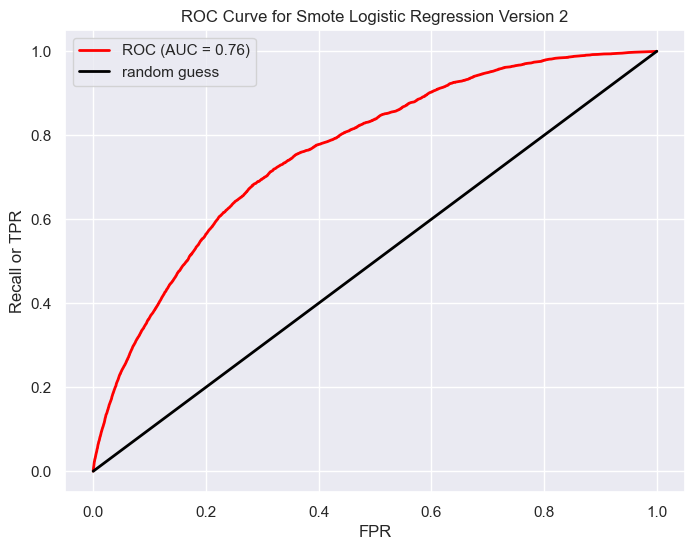

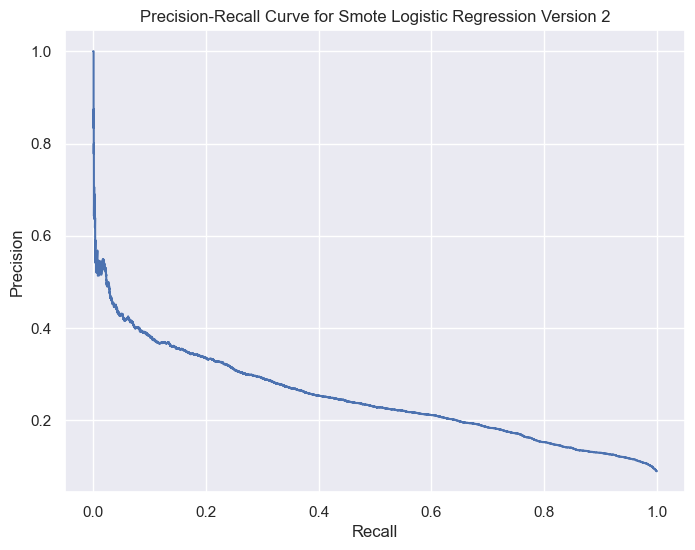

In [132]:
# Calling the ROC curve function
ROC_PR_Curve(X_test, y_test, smote_logit_model_v2, 'Smote Logistic Regression Version 2')

### SMOTE Discussion:

#### Confusion Matrix Discussion:

SMOTE Version 1 Confusion Matrix Results:

              precision    recall  f1-score   support

           0       0.96      0.73      0.83     68119
           1       0.19      0.66      0.30      6726



SMOTE Version 2 Confusion Matrix Results:

              precision    recall  f1-score   support

           0       0.96      0.74      0.83     68119
           1       0.20      0.65      0.30      6726

There has been a slight improvement on the models precision with regards to the negative class, but the recall of the model with regards to the negative class gone down slightly in the process.  Recall of the positive class has slightly improved.


#### Score Analysis:

A reminder of SMOTE Version 1 Scores:

- F1 score: 30.1%
- Recall score: 65.7%
- Precision score: 19.5%
- Train Accuracy score: 72.4%
- Test Accuracy score: 72.5%

SMOTE Version 2 Scores:

- F1 score: 30.4%
- Recall score: 66.4%
- Precision score: 19.7%
- Train Accuracy score: 73.0%
- Test Accuracy score: 72.9%

Optimisation of the hyperparameters has had a very small affect on model performance. Overall recall of the model has reduced by ~1%, whilst precision, F1 and accuracy have all improved slightly from V1 to V2. Im placing more weight on recall as a metric for evaluating this model, as such I think version 1 is perhaps more valuable to the app user.

The ROC curve shows the trade-off between the true positive rate (TPR) and the false positive rate (FPR) at different thresholds. This model has an AUC value of 0.76. This is considered acceptable.

The precision-recall curve shows the tradeoff between precision and recall at different probability thresholds. A perfect model would have a precision-recall curve that hugs the top right corner, i.e. high precision and high recall across all thresholds.

The curve shows that the precision is high at the low end of the recall scale but then drops off as recall increases. This drop-off is indicative of the increase in false positive predictions as recall increases. This can be seen by the curve flattening out and moving towards the bottom left corner of the chart.

I'll extract the feature importance of each model in the summary of the logistic regression section.



---

### RandomOverSampling GridSearchCV: 

#### Version 1:

In [133]:
# # Calling the gridsearch function Using RandomOversampler
# GridSearch_logit_v1(RandomOverSampler, X_train, y_train, X_test, y_test, 'randup', c_values, '../models/log_reg_models/')

In [134]:
# Loading the model
randup_logit_version1 = joblib.load('../models/log_reg_models/randup_logit_version1.pkl')

#### Model Evaluation:

[[51362 16757]
 [ 1624  5102]]


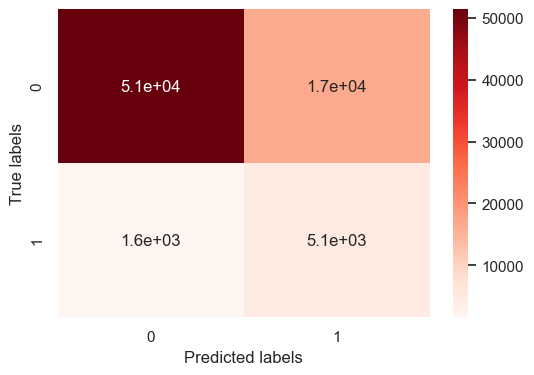

              precision    recall  f1-score   support

           0       0.97      0.75      0.85     68119
           1       0.23      0.76      0.36      6726

    accuracy                           0.75     74845
   macro avg       0.60      0.76      0.60     74845
weighted avg       0.90      0.75      0.80     74845

F1 score: 35.7%
Recall score: 75.9%
Precision score: 23.3%
Train Accuracy score: 75.3%
Test Accuracy score: 75.4%
The Parameters of this model are {'log_model': LogisticRegression(C=0.001, max_iter=10000, n_jobs=-1, random_state=1), 'log_model__C': 0.001, 'log_model__penalty': 'l2', 'log_model__solver': 'lbfgs', 'scaler': MaxAbsScaler()}


In [135]:
# Calling the model evaluation function
model_eval(X_train, y_train, X_test, y_test, randup_logit_version1)

#### Score analysis:

Reminder of SMOTE v2 metrics

Smote v2:
- F1 score: 30.4%
- Recall score: 66.4%
- Precision score: 19.7%
- Train Accuracy score: 73.0%
- Test Accuracy score: 72.9%

RandomOverSampling v1:
- F1 score: 35.7%
- Recall score: 75.9%
- Precision score: 23.3%
- Train Accuracy score: 75.3%
- Test Accuracy score: 75.4%

The oversampled V1 model has achieved a train accuracy score of 75.3% and a test accuracy score of 75.4%. This a significant improvement compared to the SMOTE v2 model, and implies that the oversampled model is performing well on unseen data and is not overfitting.

By optimising the model through the use of the randomly oversampled data, recall score has improved by approximately 9% compared to SMOTE v2. This improvement in recall indicates that the model is better at identifying true positive cases of CVD. Precision has also improved by ~3%, this improvement indicates that the randomly oversampled model is making less false positive predictions compared to SMOTE v2.

The improvement in these metrics might grant some credence to my theory that there are very few cases of 'hard-to-learn' minority class examples. A detriment to random oversampling is that the model can become very overfitted, however, I think over sampling in this case has reinforced the few patterns that do exist and aided in classification. 

The optimal value for the C parameter lies around 0.001. I'm going to pass through some new c_values to the model around this value.

Again, I'll hold off any ROC analysis until the final model. 

It's worth noting that the time taken to run this was only ~4 minutes! I'll continue to test RandomOverSampling with the other ML methods.




Actions for RandomOverSampling version 2: 

- Provide a new range of c_values around 1x10-3.


### RandomOverSampling Model 

#### Version 2:

In [136]:
# # Creating a new list of c values
# randup_v2_C_values = [0.001, 0.00075, 0.0005, 0.0025, 0.005]

# # Creating Pipeline
# estimators_v2_randup = [
#     ('sampling', RandomOverSampler(random_state=1)),
#     ('scaler', MinMaxScaler()),
#     ('log_model', LogisticRegression(random_state=1))
# ]

# pipe_v2_randup = imbPipeline(estimators_v2_randup)

# # Creating our parameters to feed our GridSearchCV
# params_v2_randup = [    

#     # l2 with PCA, solver lbfgs
#     {'log_model': [LogisticRegression(random_state=1, n_jobs=-1, max_iter=10000)],
#      'log_model__solver': ['lbfgs'],
#      'log_model__penalty': ['l2'],
#      'log_model__C': randup_v2_C_values},
#     ] 

# grid_v2_randup = GridSearchCV(pipe_v2_randup, param_grid=params_v2_randup, cv=5, \
#                                    n_jobs=-1, scoring={'f1': f1_made, 'recall': recall_made, 
#                                                        'precision':precision_made, 'accuracy': accuracy_made}, refit='f1', verbose=1)

# fittedgrid_v2_randup = grid_v2_randup.fit(X_train, y_train)


# # Print the best hyperparameters and corresponding mean score for the train dataset
# print("Best parameters: ", fittedgrid_v2_randup.best_params_)
# print("Best F1 train score: ", fittedgrid_v2_randup.best_score_)

# test_score_v2_randup = fittedgrid_v2_randup.score(X_test, y_test)
# print("Test F1 score SMOTE Data: ", test_score_v2_randup)

In [137]:
# Saving the optimised model as a pkl
# joblib.dump(fittedgrid_v2_randup, '../models/log_reg_models/randup_logit_version2.pkl')

# Loading the pkl for analysis
randup_logit_model_v2 = joblib.load('../models/log_reg_models/randup_logit_version2.pkl')

#### Model Evaluation:

[[50872 17247]
 [ 1560  5166]]


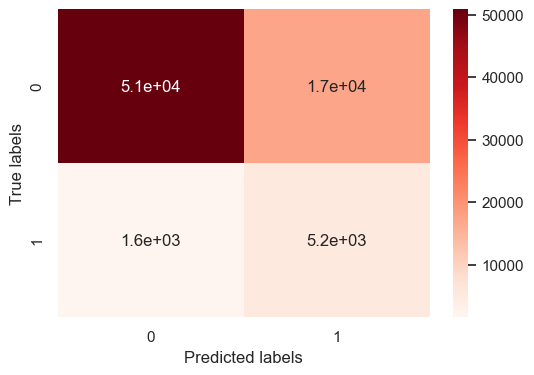

              precision    recall  f1-score   support

           0       0.97      0.75      0.84     68119
           1       0.23      0.77      0.35      6726

    accuracy                           0.75     74845
   macro avg       0.60      0.76      0.60     74845
weighted avg       0.90      0.75      0.80     74845

F1 score: 35.5%
Recall score: 76.8%
Precision score: 23.0%
Train Accuracy score: 74.7%
Test Accuracy score: 74.9%
The Parameters of this model are {'log_model': LogisticRegression(C=0.00075, max_iter=10000, n_jobs=-1, random_state=1), 'log_model__C': 0.00075, 'log_model__penalty': 'l2', 'log_model__solver': 'lbfgs'}


In [138]:
# Calling the model evaluation function
model_eval(X_train, y_train, X_test, y_test, randup_logit_model_v2)

ROC AUC score: 0.8353330118620099


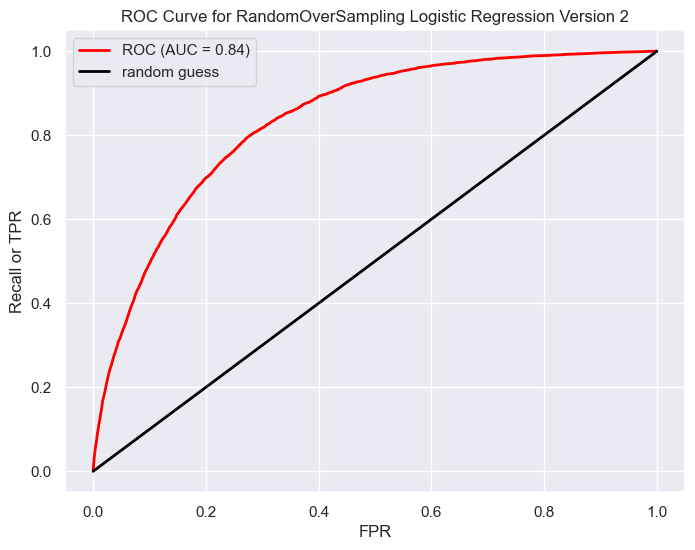

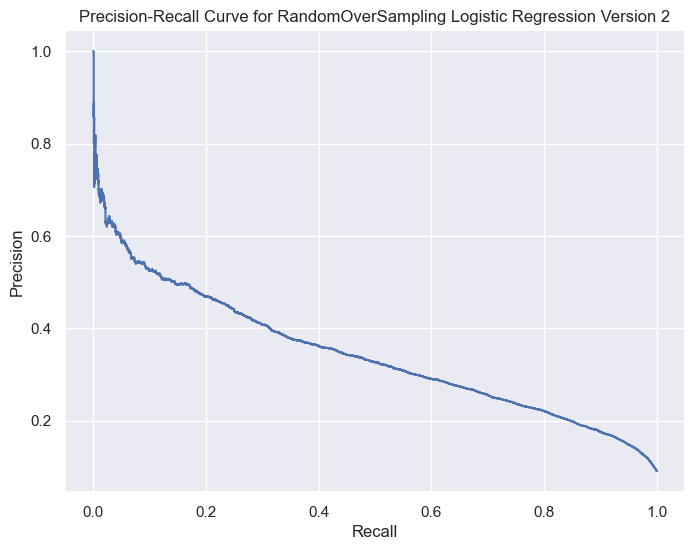

In [139]:
# Calling the ROC curve function
ROC_PR_Curve(X_test, y_test, randup_logit_model_v2, 'RandomOverSampling Logistic Regression Version 2')

### RandomOverSampling Discussion:

#### Confusion Matrix Discussion:

**RandOver version 1:**

[[51362 16757]

[ 1624  5102]]

         precision    recall  f1-score   support

      0       0.97      0.75      0.85     68119
      1       0.23      0.76      0.36      6726


**RandOver version 2:**

[[50872 17247]

 [ 1560  5166]]
      
      0       0.97      0.75      0.84     68119
      1       0.23      0.77      0.35      6726

There has been a slight improvement on the recall score with regards to the positive class. In all other cases, precision and recall scores have remained unchanged. F1 score for the positive class has gone down by 1%.   
These changes reflect the observed number of observations in the true positive and false positive sections of the confusion matrix from v1 to v2. From v1 to v2, the number of true positive predictions increased by 64 and then number of false positive predictions increased by 490. The added value of true positive predictions is debatable. My final app will be returning a percentage likelihood of CVD and not a 'hard prediction', the added false positives may only equate to a 1-2% increase/decrease in likelihood. Users will view such values as roughly equal.  

#### Score analysis:

RandomOverSampling v1:
- F1 score: 35.7%
- Recall score: 75.9%
- Precision score: 23.3%
- Train Accuracy score: 75.3%
- Test Accuracy score: 75.4%

RandomOverSampling v2:
- F1 score: 35.5%
- Recall score: 76.8%
- Precision score: 23.0%
- Train Accuracy score: 74.7%
- Test Accuracy score: 74.9%

The oversampled V2 model has achieved a train accuracy score of 74.7% and a test accuracy score of 74.9%. This is a reduction of around 0.5% compared to version 1. Precision  is also slightly worse than version 1 with a reduction of around 0.3%, this means the version 2 model is making slightly more false positive predictions compared to model 1. 

However, by optimising the model C value, recall score has improved by approximately 1% compared to version 1, Im placing more weight on recall score than precision and am going to class this model as an improvement over version 1. 

This model has an AUC value of 0.84, this is a massive improvement on the SMOTE model and is considered a good AUC value.

The precision-recall curve shows the tradeoff between precision and recall at different probability thresholds. A perfect model would have a precision-recall curve that hugs the top right corner, i.e. high precision and high recall across all thresholds.

The curve shows an improvement compared to the one obtained from the SMOTE model. At the lower end of the recall scale, the precision is high, but it gradually declines at a shallower gradient compared to the previous model as recall increases. Again, this drop-off is indicative of the increase in false positive predictions as recall increases. 

I'll extract the feature importance of each model in the summary of the logistic regression section.


---

### RandomUnderSampling GridSearchCV:

#### Version 1:

In [140]:
# # Calling the v1 logitsitc regression function using randomundersampling
# GridSearch_logit_v1(RandomUnderSampler, X_train, y_train, X_test, y_test, 'randund', c_values, '../models/log_reg_models/')

In [141]:
# loading the model
randund_logit_version1 = joblib.load('../models/log_reg_models/randund_logit_version1.pkl')

#### Model Evaluation:

[[50540 17579]
 [ 1492  5234]]


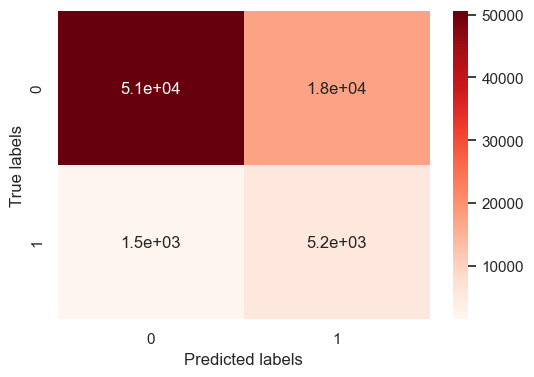

              precision    recall  f1-score   support

           0       0.97      0.74      0.84     68119
           1       0.23      0.78      0.35      6726

    accuracy                           0.75     74845
   macro avg       0.60      0.76      0.60     74845
weighted avg       0.90      0.75      0.80     74845

F1 score: 35.4%
Recall score: 77.8%
Precision score: 22.9%
Train Accuracy score: 74.3%
Test Accuracy score: 74.5%
The Parameters of this model are {'log_model': LogisticRegression(C=0.1, max_iter=10000, n_jobs=-1, random_state=1), 'log_model__C': 0.1, 'log_model__penalty': 'l2', 'log_model__solver': 'lbfgs', 'scaler': MaxAbsScaler()}


In [142]:
# Calling the model evaluation function
model_eval(X_train, y_train, X_test, y_test, randund_logit_version1)

#### Score analysis:

Reminder of over sampling v2 metrics

Random Oversampling v2:
- F1 score: 35.5%
- Recall score: 76.8%
- Precision score: 23.0%
- Train Accuracy score: 74.7%
- Test Accuracy score: 74.9%

RandomUnderSampling v1:
- F1 score: 35.4%
- Recall score: 77.8%
- Precision score: 22.9%
- Train Accuracy score: 74.3%
- Test Accuracy score: 74.5%

The under sampled V1 model has achieved a train accuracy score of 74.3% and a test accuracy score of 74.5%. This a slight decrease compared to the over sampling v2 model. Again, this implies that the under sampled model is performing well on unseen data and is not overfitting.

By optimising the model through the use of RandomUnderSample, recall score has improved by approximately 1% compared to RandomOverSampling v2. This improvement in recall indicates that the model is better at identifying true positive cases of CVD. Precision and F1 scores have decreased by ~0.1%, the performance difference in these metrics compared to over sampling is near negligible.

RandomUnderSampling has returned the best recall score. My current theory regarding this is that there might be lots of noise in the majority sample that random undersampling negates. Thus, it may improve the recall score because the model is better able to discern the patterns of the minority class. This reasoning gives slightly more evidence towards my theory that the data is not very complex and has a low number of 'hard-to-learn' patterns. A smaller amount of data has resulted in an equal ability for the model to predict the majority class. 

The optimal value for the C parameter lies around 0.1. I'm going to pass through some new c_values to the model around this value.

Again, I'll hold off any ROC analysis until the final model. 

Given the results and speed of training, i'll be carrying this sampling method forwards to other ML models.



### RandomUnderSampling GridSearchCV:

#### Version 2:

In [143]:
# # Creating a new list of c values
# randund_v2_C_values = [0.1, 0.075, 0.05, 0.25, 0.5]

# # Creating Pipeline
# estimators_v2_randund = [
#     ('sampling', RandomOverSampler(random_state=1)),
#     ('scaler', MinMaxScaler()),
#     ('log_model', LogisticRegression(random_state=1))
# ]

# pipe_v2_randund = imbPipeline(estimators_v2_randund)

# # Creating our parameters to feed our GridSearchCV
# params_v2_randund = [    

#     # l2 with PCA, solver lbfgs
#     {'log_model': [LogisticRegression(random_state=1, n_jobs=-1, max_iter=10000)],
#      'log_model__solver': ['lbfgs'],
#      'log_model__penalty': ['l2'],
#      'log_model__C': randund_v2_C_values},
#     ] 

# grid_v2_randund = GridSearchCV(pipe_v2_randund, param_grid=params_v2_randund, cv=5, \
#                                    n_jobs=-1, scoring={'f1': f1_made, 'recall': recall_made, 
#                                                        'precision':precision_made, 'accuracy': accuracy_made}, refit='f1', verbose=1)

# fittedgrid_v2_randund = grid_v2_randund.fit(X_train, y_train)


# # Print the best hyperparameters and corresponding mean score for the train dataset
# print("Best parameters: ", fittedgrid_v2_randund.best_params_)
# print("Best F1 train score: ", fittedgrid_v2_randund.best_score_)

# test_score_v2_randund = fittedgrid_v2_randund.score(X_test, y_test)
# print("Test F1 score SMOTE Data: ", test_score_v2_randund)

In [144]:
# # Saving the optimised model as a pkl
# joblib.dump(fittedgrid_v2_randund, '../models/log_reg_models/randund_logit_version2.pkl')

# Loading the pkl for analysis
randund_logit_model_v2 = joblib.load('../models/log_reg_models/randund_logit_version2.pkl')

#### Model Evaluation:

[[50329 17790]
 [ 1472  5254]]


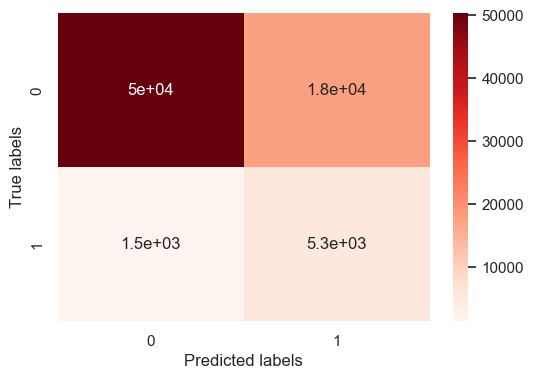

              precision    recall  f1-score   support

           0       0.97      0.74      0.84     68119
           1       0.23      0.78      0.35      6726

    accuracy                           0.74     74845
   macro avg       0.60      0.76      0.60     74845
weighted avg       0.90      0.74      0.80     74845

F1 score: 35.3%
Recall score: 78.1%
Precision score: 22.8%
Train Accuracy score: 74.1%
Test Accuracy score: 74.3%
The Parameters of this model are {'log_model': LogisticRegression(C=0.05, max_iter=10000, n_jobs=-1, random_state=1), 'log_model__C': 0.05, 'log_model__penalty': 'l2', 'log_model__solver': 'lbfgs'}


In [145]:
# Calling the model evaluation function
model_eval(X_train, y_train, X_test, y_test, randund_logit_model_v2)

ROC AUC score: 0.8373131964663628


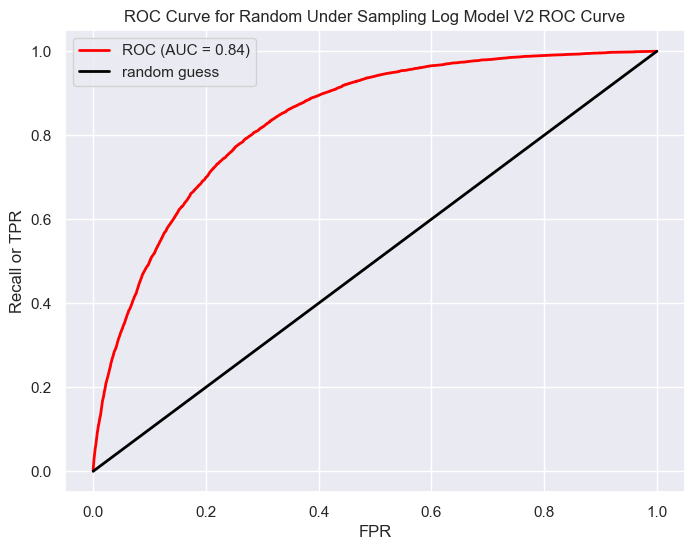

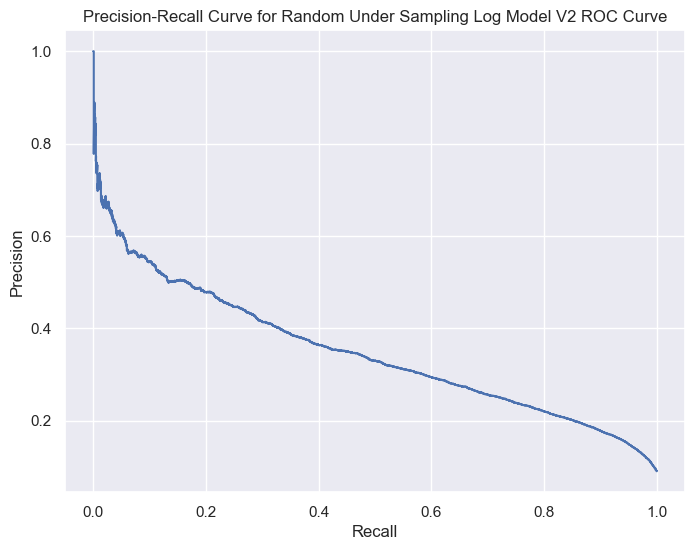

In [146]:
# Calling the ROC curve function
ROC_PR_Curve(X_test, y_test, randund_logit_model_v2, 'Random Under Sampling Log Model V2 ROC Curve')

### RandomUnderSampling Discussion:

#### Confusion Matrix Discussion:

**RandUnder version 1:**

[[50540 17579]

 [ 1492  5234]]

           precision   recall  f1-score   support

      0       0.97      0.74      0.84     68119
      1       0.23      0.78      0.35      6726


**RandUnder version 2:**

[[50329 17790]

 [ 1472  5254]]
      
           precision   recall  f1-score   support

      0       0.97      0.74      0.84     68119
      1       0.23      0.78      0.35      6726

There is close to no difference in precision and recall between the two models with regards to the classes. Version two has made 20 more true positive predictions whilst also making 221 more false negative predictions. Again the as the app will return a percent likelihood of CVD and not a hard prediction, these differences are negligible. 

#### Score analysis:

RandomUnderSampling v1:
- F1 score: 35.4%
- Recall score: 77.8%
- Precision score: 22.9%
- Train Accuracy score: 74.3%
- Test Accuracy score: 74.5%

RandomUnderSampling v2:
- F1 score: 35.3%
- Recall score: 78.1%
- Precision score: 22.8%
- Train Accuracy score: 74.1%
- Test Accuracy score: 74.3%

The undersampled v2 model has achieved a train accuracy score of 74.1% and a test accuracy score of 74.3%. This is a minor increase of around 0.2% compared to version 1. Precision and F1 scores are slightly worse than version 1 with a reduction of around 0.1% each.

However, by optimising the model C value, recall score has improved by approximately 0.3% compared to version 1, Im placing more weight on recall score than precision and am going to class this model as an improvement over version 1. 

This model has an AUC value of 0.84, this is identical to the random over sampled model.

The precision recall curve is identical to that of the oversampled model.

I'll extract the feature importance of each model in the summary of the logistic regression section.

---

### Logistic Regression Summary:

Now all logistic regression models have been run, I can extract feature importance of the best model. The scikit-learn logistic regression attribute `.coef` will allow me to do this for each model. Im going to create a dataframe with the coefficients of each model as columns. GridSearch does not have a .coef_ attribute, I therefore need to access it by first returning the model object, with `.best_estimator_`, then the pipeline object with `named_steps` then the coefficients with `.coef`

In [147]:
# Extracting model coefficients
best_smote_coeffs = smote_logit_model_v1.best_estimator_.named_steps.log_model.coef_[0]
best_randup_coeffs = randup_logit_model_v2.best_estimator_.named_steps.log_model.coef_[0]
best_randund_coeffs = randund_logit_model_v2.best_estimator_.named_steps.log_model.coef_[0]


In [148]:
# Extracting feature names from X_train
feature_names = X_train.columns.tolist()

# Creating a DataFrame of feature names and their importance
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Smote_Coeffs': best_smote_coeffs,
    'RandomOver_Coeffs': best_randup_coeffs,
    'RandomUnder_Coeffs': best_randund_coeffs,
})


# display the feature importance DataFrame
feature_importance

,Feature,Smote_Coeffs,RandomOver_Coeffs,RandomUnder_Coeffs
0,BMI,0.063621,0.103313,0.584036
1,Smoking,0.047899,0.353294,0.344037
2,AlcoholDrinking,-0.387916,-0.225775,-0.237268
3,Stroke,0.068190,0.926329,1.162912
4,PhysicalHealth,0.387355,0.293631,0.117244
5,MentalHealth,-0.010626,0.093490,0.206086
6,DiffWalking,0.067810,0.400785,0.269049
7,Sex,0.140299,0.634808,0.742392
8,AgeCategory,1.272566,2.507175,3.455746
9,PhysicalActivity,-0.517697,-0.038424,0.044519


In [149]:
# Sorting the best model candidate.
feature_importance = feature_importance.sort_values('RandomUnder_Coeffs', ascending=True)
feature_importance


,Feature,Smote_Coeffs,RandomOver_Coeffs,RandomUnder_Coeffs
14,Race_Asian,-0.188794,-0.195676,-0.484100
2,AlcoholDrinking,-0.387916,-0.225775,-0.237268
10,SleepTime,-0.144673,-0.049272,-0.226284
15,Race_Black,-0.402476,-0.066198,-0.220046
16,Race_Hispanic,-0.455230,-0.075634,-0.131980
17,Race_Other,-0.219144,0.062745,0.013943
18,Race_White,-0.077353,0.162096,0.024653
9,PhysicalActivity,-0.517697,-0.038424,0.044519
23,"Diabetic_No, borderline diabetes",-0.137915,0.099727,0.083038
13,SkinCancer,-0.074881,0.201378,0.096307


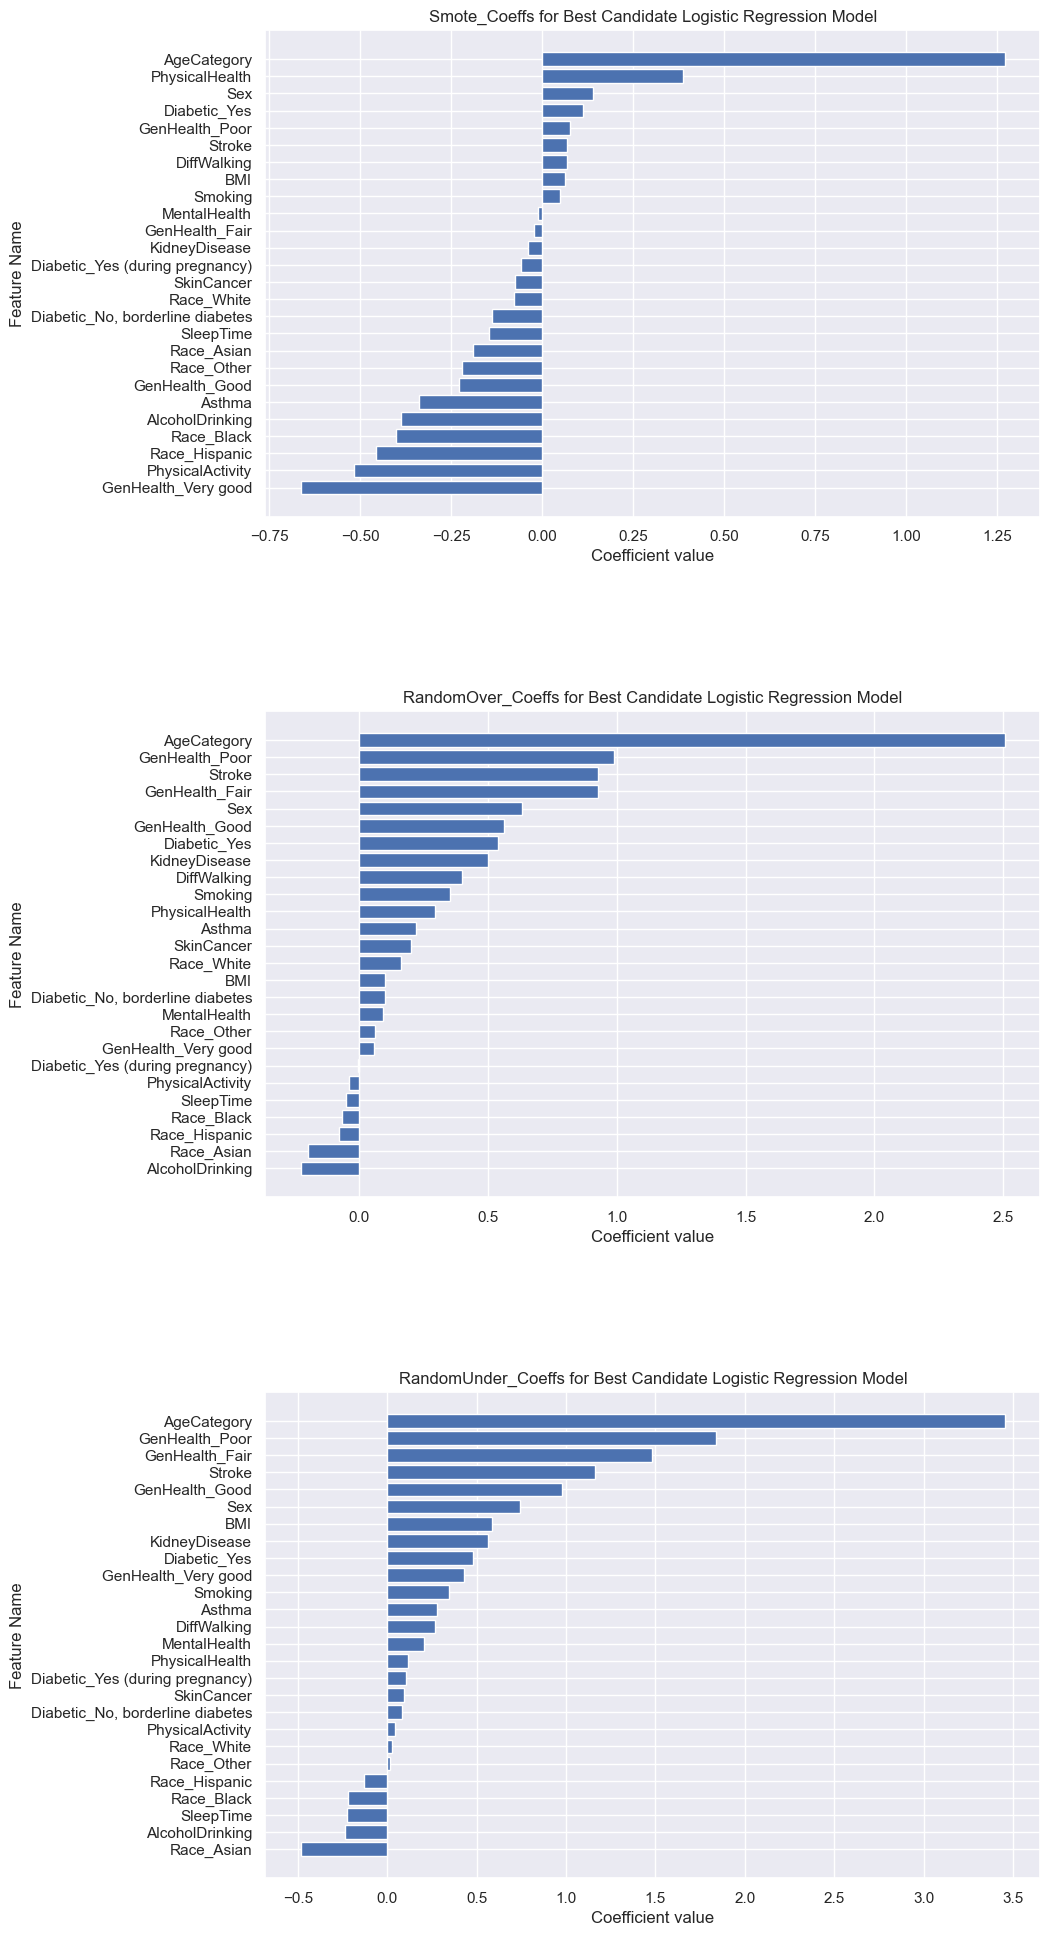

Smote model intercept value = [-0.2471811]
Random Over sample model intercept value = [-3.18604414]
Random Under sample model intercept value = [-4.21983113]


In [150]:

# Setting the style and figure size of the plot
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(10,8*len(feature_importance.columns[1:]))})

# Creating subplots for each feature importance
f, axes = plt.subplots(len(feature_importance.columns[1:]))
f.subplots_adjust(hspace=0.4)

# Iterating over each df column and creating horizontal bar plots
for index, i in enumerate(feature_importance.columns[1:]):
    feature_importance = feature_importance.sort_values(i, ascending=True)
    axes[index].barh(feature_importance['Feature'], feature_importance[i])
    axes[index].set_xlabel('Coefficient value')
    axes[index].set_ylabel('Feature Name')
    axes[index].set_title(f'{i} for Best Candidate Logistic Regression Model')

# Displaying the plot
plt.show()

# Printing intercept values for each model
print(f'Smote model intercept value = {smote_logit_model_v1.best_estimator_.named_steps.log_model.intercept_}')
print(f'Random Over sample model intercept value = {randup_logit_model_v2.best_estimator_.named_steps.log_model.intercept_}')
print(f'Random Under sample model intercept value = {randund_logit_model_v2.best_estimator_.named_steps.log_model.intercept_}')
        

These results are quite confusing to digest all at once, lets try and distil them somewhat. 
As a reminder, the coefficients indicate the direction and magnitude of the effect of each feature on the probability of the target variable being positive. A positive coefficient means that an increase in the feature value will increase the probability of the target variable being positive, while a negative coefficient means that an increase in the feature value will decrease the probability of the target variable being positive. The larger the magnitude of the coefficient, the stronger the effect of the corresponding feature on the prediction outcome.

<p align="center">
<img src="../Visualisations/logistic_regression_equation.png" alt="Logistic Regression Equation" width="300" height="100" /> 
</p>


From the equation above we can infer that increasing the predictor by 1 unit multiplies the odds of having the outcome by e<sup>β</sup>. In addition to this, the e<sup>-(β<sub>0</sub> + β<sub>1</sub>x + ... + β<sub>n</sub>x)</sup> section of the equation will return a small value when β<sub>n</sub>x = a large value. The result of this example will be a small integer being added to the denominator of the equation, resulting higher probability value (p(x)).

&nbsp;

To aid this analysis, I'm going to remind myself of the data dictionary from my EDA notebook.

**HeartDisease**: Respondents that have ever reported having coronary heart disease (CHD) or myocardial infarction (MI).

**BMI**: Body Mass Index (BMI).

**Smoking**: Have you smoked at least 100 cigarettes in your entire life?

**AlcoholDrinking**: Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week

**Stroke**: (Ever told) (you had) a stroke?

**PhysicalHealth**: Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 days was your physical health not good? (0-30 days).

**MentalHealth**: Thinking about your mental health, for how many days during the past 30 days was your mental health not good? (0-30 days).

**DiffWalking**: Do you have serious difficulty walking or climbing stairs?

**Sex**: Are you male or female?

**AgeCategory**: Fourteen-level age category. (then calculated the mean)

**Race**: Imputed race/ethnicity value.

**Diabetic**: (Ever told) (you had) diabetes?

**PhysicalActivity**: Adults who reported doing physical activity or exercise during the past 30 days other than their regular job.

**GenHealth**: Would you say that in general your health is...

**SleepTime**: On average, how many hours of sleep do you get in a 24-hour period?

**Asthma**: (Ever told) (you had) asthma?

**KidneyDisease**: Not including kidney stones, bladder infection or incontinence, were you ever told you had kidney disease?

**SkinCancer**: (Ever told) (you had) skin cancer?


#### Smote Model Predictors:
The main positive indicators of CVD for the SMOTE model in descending order are:
- Age: I expected this to be the greatest indicator of heartdisease, EDA revealed two very distinct distributions for people with an without heartdisease based on age. Unfortunately, age cannot be used to recommend a lifestyle change. 

- Physical Health: This indicator could potentially be used to recommend lifestyle changes, however creating a tailored reccomendation is not possible given the broadness of the feature subject matter. The dictionary clarifies that PhysicalHealth refers to "how many times in the last 30 days was the users physical health not good", it does not clarify the underlying cause of these physical ailments.

- Sex: Again this is not a surprise, the increased proportion of CVD in males compared to females was statistically significant during EDA. I cannot reccomend a lifestyle change and is just included to aid model performance.

- Diabetic: This is no surprise either, having diabetes increases your risk of heart disease as per medical literature. EDA proved that the increased proportion of CVD in diabetics compared to those without was statistically significant.

Gregg EW, Gu Q, Cheng YJ, et al. Mortality trends in men and women with diabetes, 1971 to 2000. Annals of Internal Medicine. 2007;147(3):149-55.
https://pubmed.ncbi.nlm.nih.gov/17576993/

- GenHealth_poor: This is a fairly ambiguous feature and does not really allow for actionable advice. Poor health likely constitutes circumstances outside of the subjects control. As such, using this as a recommender for lifestyle change is not overly feasible. 

- Stroke: There is no surprise here, the relationship between strokes and CVD has been extensively covered in medical literature.

Association of Cardiovascular Disease Risk and Health-Related Behaviors in Stroke Patients
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9963426/

- Difficulty walking: Similar to GenHealth_poor, this is a fairly ambiguous feature, however it is likely that people that have difficulty walking are either very obese or elderly, both indicators of heart disease. 


- BMI: I expected this to have a far higher coefficient, there is extensive literature to suggest that increased BMI and CVD risk are correlated. One reason for the lower coefficient could be that the elationship between the BMI and the log odds of CVD is non-linear. If this is the case, the coefficients will not accurately reflect the true influence of BMI on the model as the risk of CVD may increase disproportionately at higher/lower levels of BMI. We can quickly check this, but first lets discuss the Smoking feature.

Body-mass index and mortality among 1.46 million white adults, Gonzalez, Hartge et el. N Engl J Med. 2010 Dec 2;363(23):2211-9. doi: 10.1056/NEJMoa1000367.
https://pubmed.ncbi.nlm.nih.gov/21121834/

- Smoking: Similarly to above, I expected this feature to have a far larger coefficient than it does. It is no mystery that smoking and heart disease are strongly correlated. Given these last two observations, I dont have a huge amount fo confidence in my SMOTE models positive coefficient features.


In contrast to this, the negative coefficients are promising, there are large negative coefficients associated with sleep time, physical activity and alcohol consumption. All three of which have extensive literature describing their relationship with CVD
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2845795/
- https://nutritionj.biomedcentral.com/articles/10.1186/s12937-021-00671-y
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6172294/

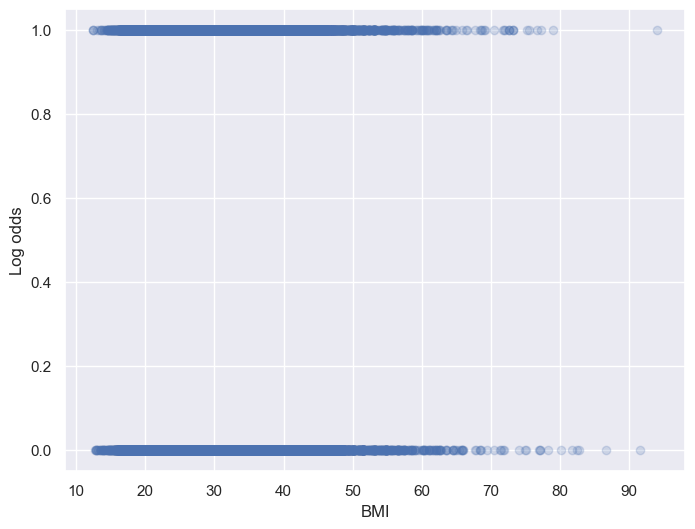

In [151]:
# Create a scatterplot of the relationship between BMI and log odds
fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(X_test['BMI'], smote_logit_model_v1.predict(X_test), alpha=0.2)
plt.xlabel('BMI')
plt.ylabel('Log odds')
plt.show()

#### RandomUnderSampling Model CVD Predictors:

I'm only going analyse the RandomUnderSampling model as it is of a slightly better quality with regards to metrics and the feature importance is very similar to that of the RandomOverSampling model. 

The logistic regression model assigns greater importance to the Smoking and BMI features compared to the previous model. Notably, mental health has a positive coefficient, indicating that a poorer mental state is associated with an increased risk of heart disease. On the other hand, sleep time and alcohol consumption have negative coefficients, suggesting that more sleep and more alcohol consumption may lower the risk of heart disease. The consistency of these findings with previous research in medical literature lends confidence in the model.
- "Depression and the Risk of Coronary Heart Disease: A Meta-Analysis of Prospective Cohort Studies" by Xu et al. (2016). Link to the paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4806458/
- "Sleep Duration and Cardiovascular Disease: Results from the KORA Augsburg Study" by Luitjens et al. (2016). Link to the paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5062423/
- Alcohol consumption and mortality from coronary heart disease: an updated meta-analysis of cohort studies. Zhao et al. Journal of studies on alcohol and drugs, 78(3), 375-386. https://doi.org/10.15288/jsad.2017.78.375

Though I dont think recommending alcohol to a user is very ethical, the other four features offer the potential for very actionable advice. It's noted that despite the lower coefficient mental health has, the benefit of improving mental health could be far greater than the coefficient implies. People with good mental health are more likely to look after themselves, which could make it easier for them to improve their sleep, exercise, and smoking habits.

---

---

## 3. DecisionTreeClassifier:

Just like my logistic regressions, prior to creation of the GridSearch I want to outline my thought process for deciding on hyperparameters.


Max Depth: 
- The maximum depth of the decision tree controls how complex the decision tree can become. The deeper the tree, the more complex it is, and the more likely it is to overfit the training data. Visa versa, if the tree is too shallow, it may not capture all the relevant patterns in the data, leading to underfitting.

Min Samples Split: 
- This hyperparameter controls the minimum number of samples required to split an internal node. A lower value will result in a more complex tree with more splits, whereas a higher value will result in a simpler tree with fewer splits. Setting a low value for min samples split may lead to overfitting, as the tree will keep splitting even on small variations in the data. Setting a high value for min samples split may lead to underfitting, as the tree will not have enough splits to capture the underlying patterns in the data.

Criterion: 
- The criterion hyperparameter determines the function to measure the quality of a split. The two most commonly used criteria are Gini impurity and entropy/information gain. 

- Gini Impurity tells us the probability of misclassifying an observation if it were labeled at random according to the distribution of lavels in a particular node. The impurity for one leaf of a decision tree is defined as: 1 - (the probability of the positive class)<sup>2</sup> - (the probability of the negative class)<sup>2</sup>. 

- Total Gini Impurity = The weighted Average of Gini Impurities for all leaves. 
- The goal with Gini is to minimise the impurity at each node by splitting the data based on the feature that maximises the reduction in impurity - StatsQuest Illustrated Guide To ML

- Entropy measures the degree of disorder or uncertainty that results when splitting the data based on a particular feature. It is calculated as the sum of the negative logarithms of the class probabilities, weighted by the probability of each class. It ranges from 0 to 1, with 1 being a completely disordered result, i.e. elements are distributed randomly among the positive and negative class. Therefore, entropy values closer to 0 are far more valuable when creating nodes.

As a note, Gini impurity is often preferred when the classes are well balanced, while entropy is often preferred when the classes are imbalanced or when the decision tree is expected to have a large depth. - ChatGPT, sources provided for the statement are as follows: 
1. Hastie, T., Tibshirani, R., & Friedman, J. (2009). The Elements of Statistical Learning: Data Mining, Inference, and Prediction (2nd ed.). Springer. https://doi.org/10.1007/978-0-387-84858-7

2. Breiman, L., Friedman, J., Stone, C. J., & Olshen, R. A. (1984). Classification and Regression Trees. Wadsworth International Group.

3. Quinlan, J. R. (1986). Induction of Decision Trees. Machine Learning, 1(1), 81–106. https://doi.org/10.1007/bf00116251

4. Han, J., & Kamber, M. (2012). Data Mining: Concepts and Techniques (3rd ed.). Morgan Kaufmann.


Max Features: 
- This hyperparameter determines the maximum number of features to consider when looking for the best split. A lower value will result in a simpler tree with fewer features, whereas a higher value will result in a more complex tree with more features. 

Class Weight: 
- The class weight hyperparameter determines how the algorithm should handle imbalanced classes. Imbalanced classes occur when one class has many more examples than the other. In such cases, the decision tree may be biased towards the majority class. By assigning a higher weight to the minority class, the algorithm can give it more importance and reduce the bias towards the majority class. The default for this is 'Balanced', which automatically adjusts the weights based on the class distribution, but Im not sure if this will interfere with the sampling. As such, Im going to include 'Balanced' and `None` as a hyperparameters. 


I have dropped SMOTE as a sampling method, I tried running a method, but the time taken was too long. 

---

In [152]:
# Creating my Gridsearch function for Decision Trees

def GridSearch_DT_v1(sampler, X_train, y_train, X_test, y_test, model_name, max_depth, min_samples, path='', suffix = '_DT_version1.pkl'):

    
    f1_made = make_scorer(f1_score)
    precision_made = make_scorer(precision_score)
    recall_made = make_scorer(recall_score)
    accuracy_made = make_scorer(accuracy_score)

    # DT estimators

    DT_estimators = [('sampling', sampler(random_state=1)),
                     ('scaler', MinMaxScaler()),
                     ('DT_model', DecisionTreeClassifier(random_state=1))]

    # Define the pipeline
    pipe = imbPipeline(DT_estimators)

    # Define the hyperparameter space to search
    hyperparameters = {
                    'DT_model__max_depth': max_depth,
                    'DT_model__min_samples_split': min_samples,
                    'DT_model__criterion': ['gini', 'entropy'],
                    'DT_model__max_features': ['sqrt', 'log2', None],
                    'DT_model__class_weight': [None, 'balanced']
                    }

    # Define the GridSearchCV object
    grid_v1_model = GridSearchCV(pipe, param_grid=hyperparameters, cv=5, \
                                   n_jobs=-1, scoring={'f1': f1_made, 'recall': recall_made, 
                                                       'precision':precision_made, 'accuracy': accuracy_made}, refit='f1', verbose=2)

    # Fit the GridSearchCV object to the training data
    fittedgrid_V1_model = grid_v1_model.fit(X_train, y_train)

    # Print the best hyperparameters and corresponding mean score for the train dataset
    print("Best parameters: ", fittedgrid_V1_model.best_params_)
    print("Best F1 train score: ", fittedgrid_V1_model.best_score_)

    test_f1_score_v1 = fittedgrid_V1_model.score(X_test, y_test)

    print("Test F1 score: ", test_f1_score_v1)
    
    return joblib.dump(fittedgrid_V1_model, f'{path}{model_name}{suffix}')

    

### RandomOverSampler

#### Version 1:

In [153]:
# Assigning hyperparameters for the gridsearch
min_samples = [2, 4, 6, 8, 10]
max_depth = [2, 4, 6, 8, 10]

# # Calling gridsearch decision tree function with oversampled data
# GridSearch_DT_v1(RandomOverSampler, X_train, y_train, X_test, y_test,'randup', max_depth, min_samples, '../models/decision_tree_models/')

In [154]:
# Loading the output to a variable
randup_DT_v1 = joblib.load('../models/decision_tree_models/randup_DT_version1.pkl')

[[49919 18200]
 [ 1610  5116]]


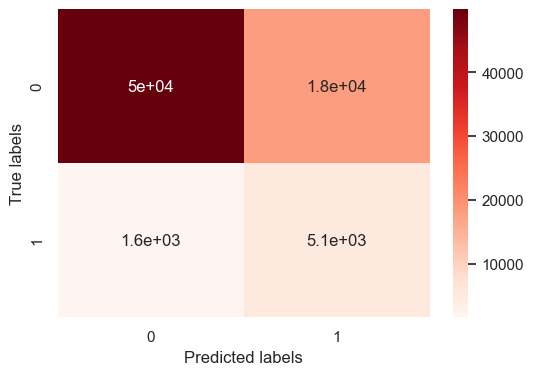

              precision    recall  f1-score   support

           0       0.97      0.73      0.83     68119
           1       0.22      0.76      0.34      6726

    accuracy                           0.74     74845
   macro avg       0.59      0.75      0.59     74845
weighted avg       0.90      0.74      0.79     74845

F1 score: 34.1%
Recall score: 76.1%
Precision score: 21.9%
Train Accuracy score: 74.1%
Test Accuracy score: 73.5%
The Parameters of this model are {'DT_model__class_weight': None, 'DT_model__criterion': 'gini', 'DT_model__max_depth': 10, 'DT_model__max_features': None, 'DT_model__min_samples_split': 2}


In [155]:
# Calling the model eval function
model_eval(X_train, y_train, X_test, y_test, randup_DT_v1)

The recall and precision scores are fairly comparable to the Logistic regression models. At the risk of repeating myself too much, I'll go through the analysis of each model in the summary section. 

Notes for version 2:
- The best Max depth parameter is at the limit of the range provided, as such i'll provide a new range of values from 10-20.

### Random Oversampler Version 2:

In [156]:
# max_depth_v2 = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

# randup_DT_V2_estimators = [('sampling', RandomOverSampler(random_state=1)),
#                      ('scaler', MinMaxScaler()),
#                      ('DT_model', DecisionTreeClassifier(random_state=1, min_samples_split=2, criterion='gini'))]

#     # Define the pipeline
# randup_DT_pipe_v2 = imbPipeline(randup_DT_V2_estimators)

#     # Define the hyperparameter space to search
# randup_DT_hyperparameters_v2 = {
#                 'DT_model__max_depth': max_depth_v2,
#                 }
# # Define the GridSearchCV object
# grid_randup_DT_v2_model = GridSearchCV(randup_DT_pipe_v2, param_grid=randup_DT_hyperparameters_v2, cv=5, \
#                                n_jobs=-1, scoring={'f1': f1_made, 'recall': recall_made, 
#                                                    'precision':precision_made, 'accuracy': accuracy_made}, refit='f1', verbose=2)

# # Fit the GridSearchCV object to the training data
# fittedgrid_randup_DT_v2_model = grid_randup_DT_v2_model.fit(X_train, y_train)

# # Print the best hyperparameters and corresponding mean score for the train dataset
# print("Best parameters: ", fittedgrid_randup_DT_v2_model.best_params_)
# print("Best F1 train score: ", fittedgrid_randup_DT_v2_model.best_score_)

# test_f1_score_v1 = fittedgrid_randup_DT_v2_model.score(X_test, y_test)

# print("Test F1 score: ", test_f1_score_v1)
    
# joblib.dump(fittedgrid_randup_DT_v2_model, '../models/decision_tree_models/randup_DT_version2.pkl')

In [157]:
# Loading the model and calling the modele val function
randup_DT_v2 = joblib.load('../models/decision_tree_models/randup_DT_version2.pkl')


[[49919 18200]
 [ 1610  5116]]


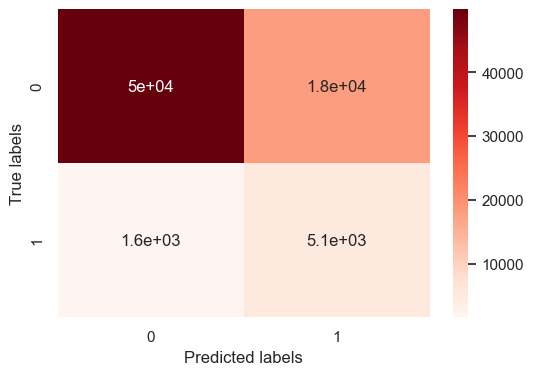

              precision    recall  f1-score   support

           0       0.97      0.73      0.83     68119
           1       0.22      0.76      0.34      6726

    accuracy                           0.74     74845
   macro avg       0.59      0.75      0.59     74845
weighted avg       0.90      0.74      0.79     74845

F1 score: 34.1%
Recall score: 76.1%
Precision score: 21.9%
Train Accuracy score: 74.1%
Test Accuracy score: 73.5%
The Parameters of this model are {'DT_model__max_depth': 10}


In [158]:
# Calling the model_eval function
model_eval(X_train, y_train, X_test, y_test, randup_DT_v2)

ROC AUC score: 0.8114633939590342


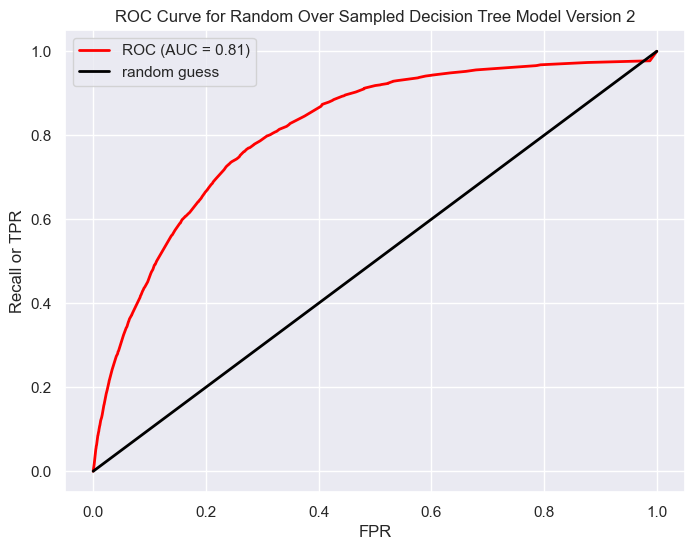

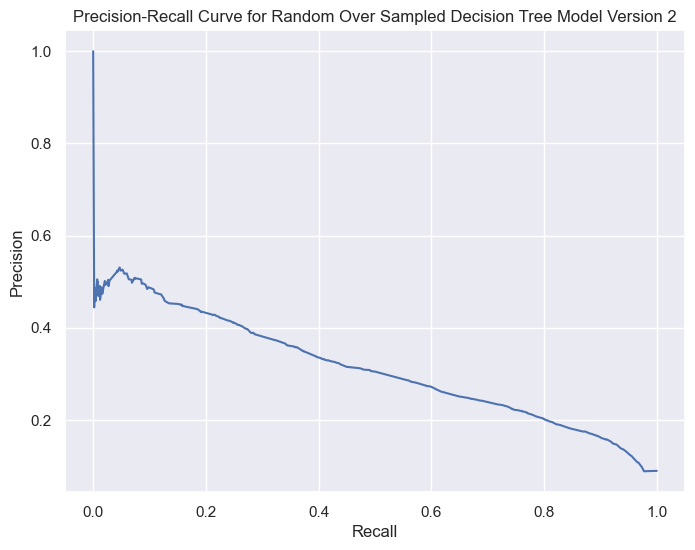

In [159]:
# Calling the ROC curve function
ROC_PR_Curve(X_test, y_test, randup_DT_v2, 'Random Over Sampled Decision Tree Model Version 2')

---

### RandomUnderSampler Decision Tree
#### Version 1:

In [160]:
# # Calling the gridsearch decision tree function on randomly undersampled data
# GridSearch_DT_v1(RandomUnderSampler, X_train, y_train, X_test, y_test, 'randund', max_depth, min_samples, '../models/decision_tree_models/')

In [161]:
# Loading the results from the gridsearch and calling the mdoel eval function
randund_DT_v1 = joblib.load('../models/decision_tree_models/randund_DT_version1.pkl')

[[49077 19042]
 [ 1611  5115]]


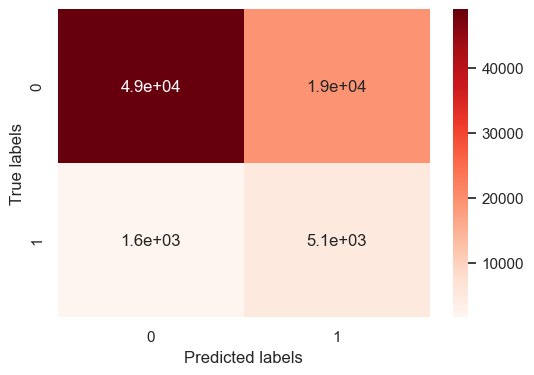

              precision    recall  f1-score   support

           0       0.97      0.72      0.83     68119
           1       0.21      0.76      0.33      6726

    accuracy                           0.72     74845
   macro avg       0.59      0.74      0.58     74845
weighted avg       0.90      0.72      0.78     74845

F1 score: 33.1%
Recall score: 76.0%
Precision score: 21.2%
Train Accuracy score: 73.1%
Test Accuracy score: 72.4%
The Parameters of this model are {'DT_model__class_weight': None, 'DT_model__criterion': 'gini', 'DT_model__max_depth': 10, 'DT_model__max_features': None, 'DT_model__min_samples_split': 10}


In [162]:
# Calling the model eval function
model_eval(X_train, y_train, X_test, y_test, randund_DT_v1)

### RandomUnderSampler Decision Tree
#### Version 2:

In [163]:
# # Creating new V2 hyperparameters to pass to the gridsearch based on output from model version 1
# max_depth_v2 = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
# min_sample_split_v2 = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

# randund_DT_V2_estimators = [('sampling', RandomUnderSampler(random_state=1)),
#                      ('scaler', MinMaxScaler()),
#                      ('DT_model', DecisionTreeClassifier(random_state=1, criterion='gini'))]

#     # Define the pipeline
# randund_DT_pipe_v2 = imbPipeline(randund_DT_V2_estimators)

#     # Define the hyperparameter space to search
# randund_DT_hyperparameters_v2 = {
#                 'DT_model__max_depth': max_depth_v2,
#                 'DT_model__min_samples_split': min_sample_split_v2
#                 }
# # Define the GridSearchCV object
# grid_randund_DT_v2_model = GridSearchCV(randund_DT_pipe_v2, param_grid=randund_DT_hyperparameters_v2, cv=5, \
#                                n_jobs=-1, scoring={'f1': f1_made, 'recall': recall_made, 
#                                                    'precision':precision_made, 'accuracy': accuracy_made}, refit='f1', verbose=2)

# # Fit the GridSearchCV object to the training data
# fittedgrid_randund_DT_v2_model = grid_randund_DT_v2_model.fit(X_train, y_train)

# # Print the best hyperparameters and corresponding mean score for the train dataset
# print("Best parameters: ", fittedgrid_randund_DT_v2_model.best_params_)
# print("Best F1 train score: ", fittedgrid_randund_DT_v2_model.best_score_)

# test_f1_score_v1 = fittedgrid_randund_DT_v2_model.score(X_test, y_test)

# print("Test F1 score: ", test_f1_score_v1)
    
# joblib.dump(fittedgrid_randund_DT_v2_model, '../models/decision_tree_models/randund_DT_version2.pkl')

In [164]:
# Loading the results from the gridsearch
randund_DT_v2 = joblib.load('../models/decision_tree_models/randund_DT_version2.pkl')

[[49125 18994]
 [ 1648  5078]]


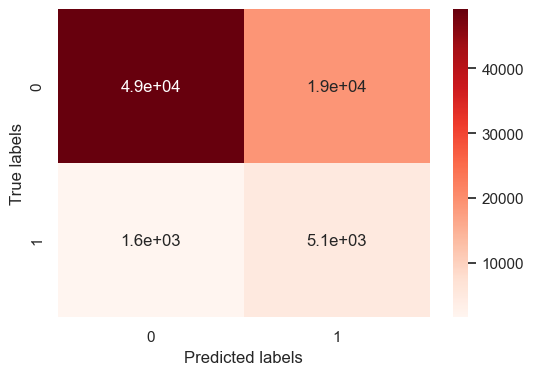

              precision    recall  f1-score   support

           0       0.97      0.72      0.83     68119
           1       0.21      0.75      0.33      6726

    accuracy                           0.72     74845
   macro avg       0.59      0.74      0.58     74845
weighted avg       0.90      0.72      0.78     74845

F1 score: 33.0%
Recall score: 75.5%
Precision score: 21.1%
Train Accuracy score: 73.2%
Test Accuracy score: 72.4%
The Parameters of this model are {'DT_model__max_depth': 11, 'DT_model__min_samples_split': 20}


In [165]:
# Calling the model eval function
model_eval(X_train, y_train, X_test,y_test, randund_DT_v2)

ROC AUC score: 0.8085747147805222


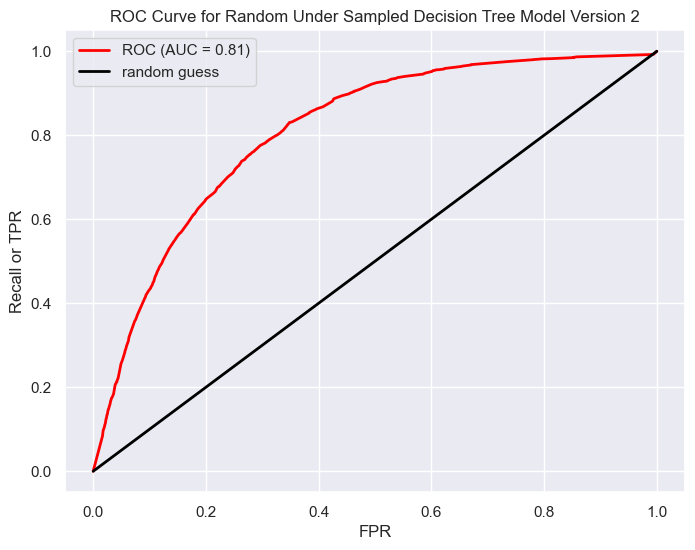

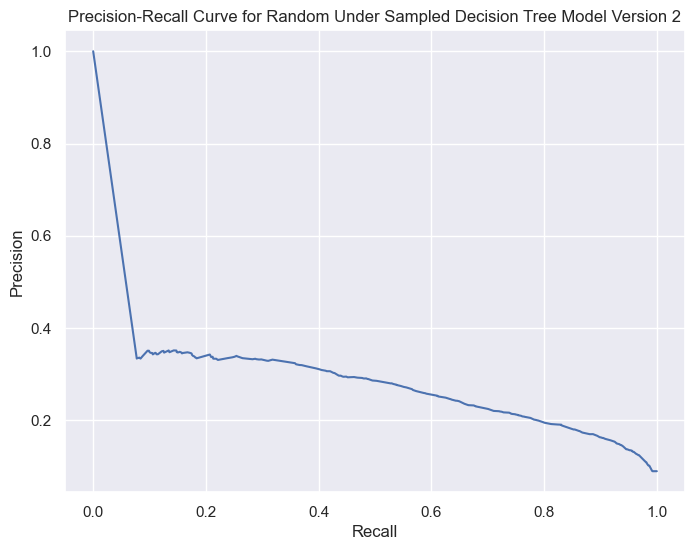

In [166]:
# Calling the ROC curve function
ROC_PR_Curve(X_test, y_test, randund_DT_v2, 'Random Under Sampled Decision Tree Model Version 2')

---

### Decision Tree Summary:

#### Confusion Matrix Discussion:

**RandOver version 2:**

[[49919 18200]

 [ 1610  5116]]

            precision   recall  f1-score   support

      0       0.97      0.73      0.83     68119
      1       0.22      0.76      0.34      6726


**RandUnder version 2:**

[[49125 18994]

 [ 1648  5078]]
      
            precision   recall  f1-score   support

      0       0.97      0.72      0.83     68119
      1       0.21      0.75      0.33      6726


RandomOverSampling seems to be the better sampling method, recall and precision are 1% higher with regards to the positive class. There is very little difference between the two models with regards to predicting the negative class. RandomOverSampling is has made 38 more true positive predictions whilst also making 794 less false negative predictions than the RandomUnderSampling method. The as the future app will return a percent likelihood of CVD and not a hard prediction, as such, these differences are fairly negligible. 

#### Score Discussion:

RandomOverSampling v2:
F1 score: 34.1%
Recall score: 76.1%
Precision score: 21.9%
Train Accuracy score: 74.1%
Test Accuracy score: 73.5%

RandomUnderSampling v2:
- F1 score: 33.0%
- Recall score: 75.5%
- Precision score: 21.1%
- Train Accuracy score: 73.2%
- Test Accuracy score: 72.4%

The RandomOverSampled v2 model has outperformed the Undersampled model in all metrics by ~1%. Train and accuracy scores for both models are within 1% of eachother. This suggests the models are not overfitted and generalise well to unseen data. Its worth noting that these models did not out perform the Logistic Regression best candidate model. 

Both models have an AUC value of 0.81. 

The precision recall curves show an initial, very steep decline in precision as recall increases. This gradient becomes shallower past a recall of ~0.1. All precision recall curves created so far have been near opposites of ideals.


### Feature Importance:

Now all decision tree models have been run, I can extract feature importance of the best model. The scikit-learn logistic regression attribute `feature_importances_` will allow me to do this for each model. Im going to create a dataframe with the coefficients of each model as columns. GridSearch does not have a .coef_ attribute, I therefore need to access it by first returning the model object, with `.best_estimator_`, then the pipeline object with `named_steps` then the coefficients with `feature_importances_`.

In [167]:
# Extracting an array of feature importance for each final version model
DT_randup_feature_importance = randup_DT_v2.best_estimator_.named_steps.DT_model.feature_importances_
DT_randund_feature_importance = randund_DT_v2.best_estimator_.named_steps.DT_model.feature_importances_


In [168]:
# Creating two dictionaries from the feature importance arrays

# Extracting the Keys for my dictionary
DT_feature_names = X_train.columns

# Creating the dictionaries
feature_importances_randup_dict = dict(zip(DT_feature_names, DT_randup_feature_importance))
feature_importances_randund_dict = dict(zip(DT_feature_names, DT_randund_feature_importance))



In [169]:
# Creating two dataframes from my dictionaries
randup_df = pd.DataFrame.from_dict(feature_importances_randup_dict, orient = 'index', columns = ['DT_randup_feature_importance'])
randund_df = pd.DataFrame.from_dict(feature_importances_randund_dict, orient = 'index', columns = ['DT_randund_feature_importance'])

In [170]:
# Concatenating the two dataframes
DT_feature_importance_df = pd.concat([randup_df, randund_df], axis = 1)
DT_feature_importance_df

,DT_randup_feature_importance,DT_randund_feature_importance
BMI,0.021397,0.052115
Smoking,0.010800,0.012215
AlcoholDrinking,0.000977,0.002881
Stroke,0.049462,0.051566
PhysicalHealth,0.006960,0.011228
MentalHealth,0.005310,0.013493
DiffWalking,0.121750,0.110066
Sex,0.065845,0.061416
AgeCategory,0.521570,0.487597
PhysicalActivity,0.001469,0.002542


In [171]:
# Renaming the index 
DT_feature_importance_df.index = DT_feature_importance_df.index.set_names(['Features'])
DT_feature_importance_df

,DT_randup_feature_importance,DT_randund_feature_importance
Features,,
BMI,0.021397,0.052115
Smoking,0.010800,0.012215
AlcoholDrinking,0.000977,0.002881
Stroke,0.049462,0.051566
PhysicalHealth,0.006960,0.011228
MentalHealth,0.005310,0.013493
DiffWalking,0.121750,0.110066
Sex,0.065845,0.061416
AgeCategory,0.521570,0.487597


In [172]:
# Reseting the index
DT_feature_importance_df = DT_feature_importance_df.reset_index()

Now we have our dataframe of feature importance, we can plot them on a horizontal bar graph. 

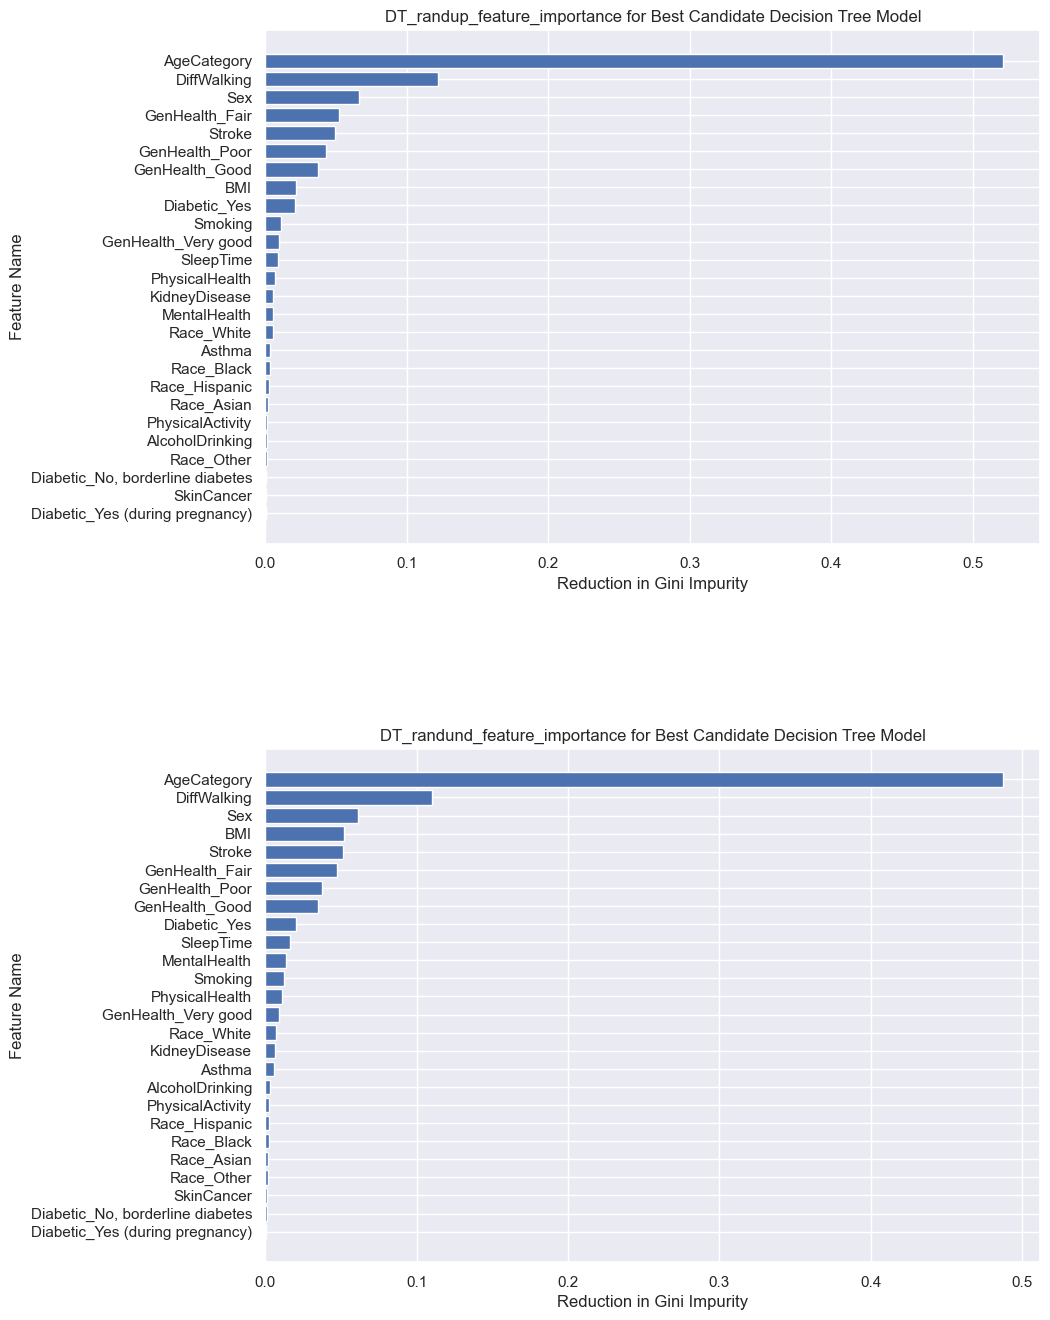

In [173]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(10,8*len(DT_feature_importance_df.columns[1:]))})
f, axes = plt.subplots(len(DT_feature_importance_df.columns[1:]))
f.subplots_adjust(hspace=0.4)

for index, i in enumerate(DT_feature_importance_df.columns[1:]):
    DT_feature_importance_df = DT_feature_importance_df.sort_values(i, ascending=True)
    axes[index].barh(DT_feature_importance_df['Features'], DT_feature_importance_df[i])
    axes[index].set_xlabel('Reduction in Gini Impurity')
    axes[index].set_ylabel('Feature Name')
    axes[index].set_title(f'{i} for Best Candidate Decision Tree Model')

plt.show()

        

A quick note on the feature importance scoring metric. The aim with Gini impurity is to minimise the sum of node impurities in the decision tree. However, feature importance looks at the contribution of each feature to the overall reduction in impurity achieved by the decision tree, i.e. The feature importance score indicates how much each feature contributes to splitting the data into homogenous groups. 

#### Notes on the feature importance:

The RandomOverSampling model has created a purer split using the age category than the RandomUndersampling. 

BMI is less important in the RandomOverSampling model compareed to Undersampling. This might be because both a low and high BMI are predictors of heart disease, as such, a homogenous split using BMI is not possible.

In both models, sleeptime, mentalhealth, physical health and smoking features have all contributed towards minimising the total Gini impurity.


---

---

## 4. Random Forest GridSearchCV

Metrics to consider:

n_estimators: 
- The number of decision trees in the random forest. Increasing the value for n_estimators inreases performance of the model, but also the computational cost. A low/high values can lead to over/underfitting.

Criterion: 
- See decision tree initial discussion. As a reminder, the criterion hyperparameter determines the function to measure the quality of a split. The two most commonly used criteria are Gini impurity and entropy/information gain.

max_depth: 
- The maximum depth of each decision tree. Increasing the value allows the trees to capture more complex patterns in the data, but increases the risk of overfitting. Smaller values may lead to underfitting.

min_samples_split: 
- The minimum number of samples required to split a node. Smaller values increase the risk of overfitting by creating too many branches in the tree. Larger values may lead to underfitting.

min_samples_leaf: 
- Similar to min_samples_split, min_samples_leaf refers to the minimum number of samples required to be at a leaf node. Smaller values increase the risk of overfitting by creating too many branches in the tree. Larger values may lead to underfitting.

bootstrap: 
- A method of inferring results for a population from results found on a collection of smaller random samples of the population, using replacement during the sampling process. - https://www.mastersindatascience.org/learning/machine-learning-algorithms/bootstrapping/#:~:text=Particularly%20useful%20for%20assessing%20the,replacement%20during%20the%20sampling%20process.

In [174]:
# Define the pipeline
def GridSearch_Random_Forest_v1(sampler, X_train, y_train, X_test, y_test, model_name, n_estimators,
                                max_depth, min_samples_leaf, min_samples_split, version, path='', 
                                suffix = '_random_forest.pkl'):

    f1_made = make_scorer(f1_score)
    precision_made = make_scorer(precision_score)
    recall_made = make_scorer(recall_score)
    accuracy_made = make_scorer(accuracy_score)

    pipe = imbPipeline([
        ('sampler', sampler(random_state = 1)),
        ('scaler', MinMaxScaler()),
        ('rf', RandomForestClassifier(random_state=1))
    ])

    # Define the hyperparameters to search over
    params = {
        'rf__n_estimators': n_estimators,
        'rf__criterion': ['gini'],
        'rf__max_depth': max_depth,
        'rf__min_samples_split': min_samples_split,
        'rf__min_samples_leaf': min_samples_leaf,
        'rf__bootstrap': [True, False]
    }

    # Define the GridSearchCV object
    grid_v1_model = GridSearchCV(pipe, param_grid=params, cv=5, \
                                   n_jobs=-1, scoring={'f1': f1_made, 'recall': recall_made, 
                                                       'precision':precision_made, 'accuracy': accuracy_made}, refit='f1', verbose=2)

    # Fit the GridSearchCV object to the training data
    fittedgrid_V1_model = grid_v1_model.fit(X_train, y_train)

    # Print the best hyperparameters and corresponding mean score for the train dataset
    print("Best parameters: ", fittedgrid_V1_model.best_params_)
    print("Best F1 train score: ", fittedgrid_V1_model.best_score_)

    test_f1_score_v1 = fittedgrid_V1_model.score(X_test, y_test)

    print("Test F1 score: ", test_f1_score_v1)
    
    return joblib.dump(fittedgrid_V1_model, f'{path}{model_name}{version}{suffix}')


### RandomOverSampling RF GridSearch:

#### Version 1:

In [175]:
# Specifying parameters for my RandomForest Gridsearch
n_estimators = [10, 50, 100, 200]
max_depth = [None, 2, 5, 10, 20]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

# # Calling the Gridsearch random forest function on randomly oversampled data
# GridSearch_Random_Forest_v1(RandomOverSampler, X_train, y_train, X_test, y_test, 'randup', n_estimators, max_depth, min_samples_leaf,
#                             min_samples_split, '_version1', '../models/random_forest_models/')

In [176]:
# Loading the output of the gridsearch and calling the model eval function
randup_rf_model_v1 = joblib.load('../models/random_forest_models/randup_version1_random_forest.pkl')


[[55542 12577]
 [ 2332  4394]]


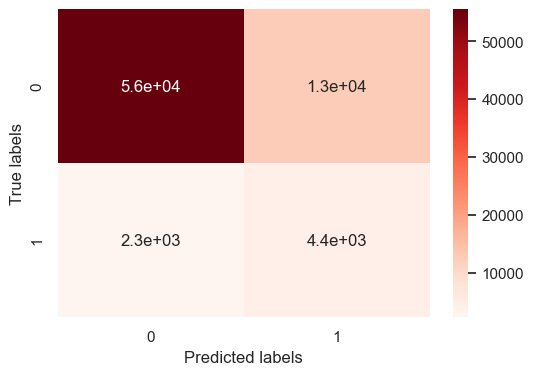

              precision    recall  f1-score   support

           0       0.96      0.82      0.88     68119
           1       0.26      0.65      0.37      6726

    accuracy                           0.80     74845
   macro avg       0.61      0.73      0.63     74845
weighted avg       0.90      0.80      0.84     74845

F1 score: 37.1%
Recall score: 65.3%
Precision score: 25.9%
Train Accuracy score: 85.2%
Test Accuracy score: 80.1%
The Parameters of this model are {'rf__bootstrap': True, 'rf__criterion': 'gini', 'rf__max_depth': 20, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}


In [177]:
# Calling the model eval function
model_eval(X_train, y_train, X_test, y_test, randup_rf_model_v1)

#### RandomOverSampling RF Version 2:

In [178]:
# Specifying parameters for my RandomForest v2 Gridsearch
n_estimators = [250, 500]
max_depth = [20, 40]
min_samples_split = [20, 40]
min_samples_leaf = [10, 20]

# # Calling the Gridsearch random forest function on randomly oversampled data v2
# GridSearch_Random_Forest_v1(RandomOverSampler, X_train, y_train, X_test, y_test, 'randup', n_estimators, max_depth, min_samples_leaf,
#                             min_samples_split, '_version2', '../models/random_forest_models/')

In [179]:
# Loading and evaluating the model using the model eval function
randup_rf_model_v2 = joblib.load('../models/random_forest_models/randup_version2_random_forest.pkl')


[[56775 11344]
 [ 2506  4220]]


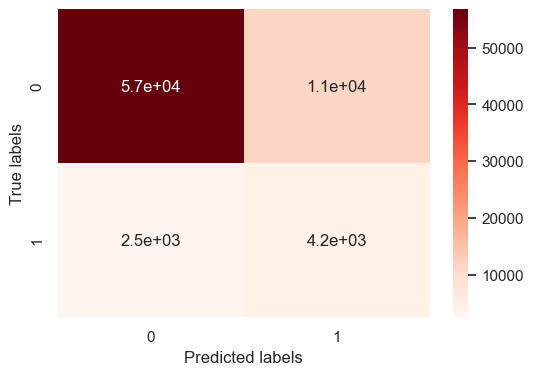

              precision    recall  f1-score   support

           0       0.96      0.83      0.89     68119
           1       0.27      0.63      0.38      6726

    accuracy                           0.81     74845
   macro avg       0.61      0.73      0.63     74845
weighted avg       0.90      0.81      0.85     74845

F1 score: 37.9%
Recall score: 62.7%
Precision score: 27.1%
Train Accuracy score: 87.2%
Test Accuracy score: 81.5%
The Parameters of this model are {'rf__bootstrap': False, 'rf__criterion': 'gini', 'rf__max_depth': 40, 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 20, 'rf__n_estimators': 500}


In [180]:
# Calling the model_eval function
model_eval(X_train, y_train, X_test, y_test, randup_rf_model_v2)

ROC AUC score: 0.8280195021483738


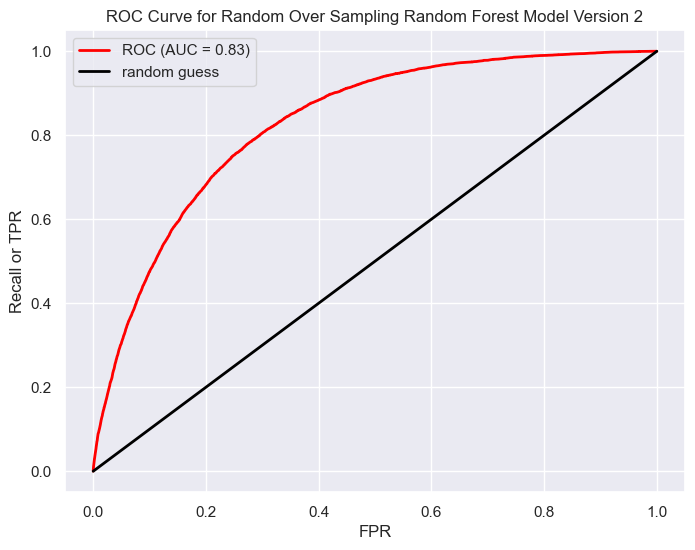

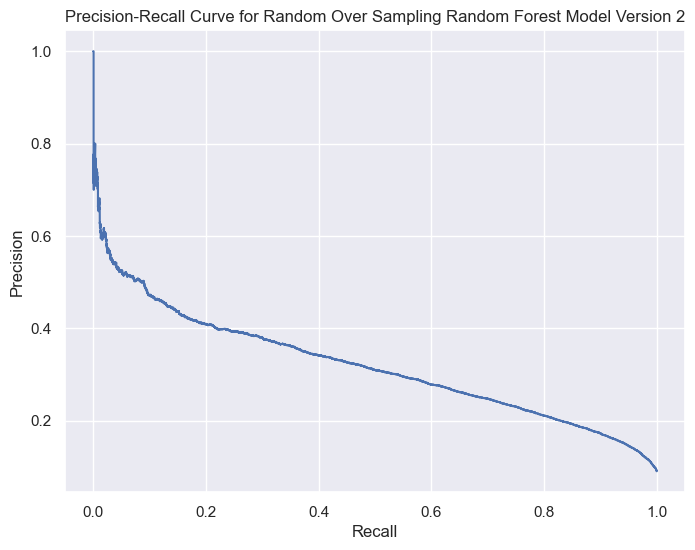

In [181]:
# Calling the ROC curve function
ROC_PR_Curve(X_test, y_test, randup_rf_model_v2, 'Random Over Sampling Random Forest Model Version 2')

Despite the results of random over sampling version 2 showing promise, the models are beginning to take too long to run, given the time constraints i'm going to stop the version iteration here. Im hoping that RandomUnderSampling doesnt take too long and I can iterate further. 

---

### RandomUnderSampling GridSearchCV

#### Version 1:

In [182]:
# Specifying parameters to pass to my RF gridsearch
n_estimators = [10, 50, 100, 200]
max_depth = [None, 2, 5, 10, 20]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

# # Calling the Gridsearch random forest function on randomly undersampled data
# GridSearch_Random_Forest_v1(RandomUnderSampler, X_train, y_train, X_test, y_test, 'randund', n_estimators, max_depth, min_samples_leaf,
#                             min_samples_split, '_version1', '../models/random_forest_models/')

In [183]:
# Loading the output of the grid search and calling the model eval function
randund_random_forest_v1 = joblib.load('../models/random_forest_models/randund_version1_random_forest.pkl')


[[48927 19192]
 [ 1346  5380]]


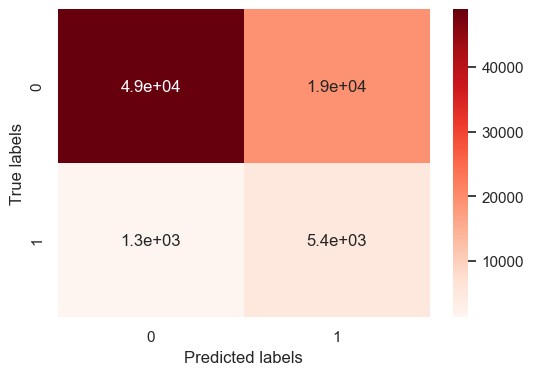

              precision    recall  f1-score   support

           0       0.97      0.72      0.83     68119
           1       0.22      0.80      0.34      6726

    accuracy                           0.73     74845
   macro avg       0.60      0.76      0.59     74845
weighted avg       0.91      0.73      0.78     74845

F1 score: 34.4%
Recall score: 80.0%
Precision score: 21.9%
Train Accuracy score: 73.6%
Test Accuracy score: 72.6%
The Parameters of this model are {'rf__bootstrap': True, 'rf__criterion': 'gini', 'rf__max_depth': 20, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}


In [184]:
# Calling the model_eval function
model_eval(X_train, y_train, X_test, y_test, randund_random_forest_v1)

#### Version 2:

In [185]:
# Specifying parameters for the v2 RF gridsearch based on the output from version 1
n_estimators = [250, 500]
max_depth = [20, 40]
min_samples_split = [20, 40]
min_samples_leaf = [10, 20]

# # Calling the v2 rf gridsearch on random undersampled data
# GridSearch_Random_Forest_v1(RandomUnderSampler, X_train, y_train, X_test, y_test, 'randund', n_estimators, max_depth, min_samples_leaf,
#                             min_samples_split, '_version2', '../models/random_forest_models/')

In [186]:
# Loading the model and calling the model eval function
randund_random_forest_v2 = joblib.load('../models/random_forest_models/randup_version2_random_forest.pkl')


[[56775 11344]
 [ 2506  4220]]


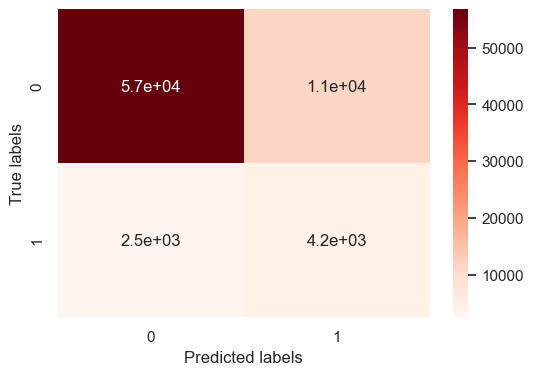

              precision    recall  f1-score   support

           0       0.96      0.83      0.89     68119
           1       0.27      0.63      0.38      6726

    accuracy                           0.81     74845
   macro avg       0.61      0.73      0.63     74845
weighted avg       0.90      0.81      0.85     74845

F1 score: 37.9%
Recall score: 62.7%
Precision score: 27.1%
Train Accuracy score: 87.2%
Test Accuracy score: 81.5%
The Parameters of this model are {'rf__bootstrap': False, 'rf__criterion': 'gini', 'rf__max_depth': 40, 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 20, 'rf__n_estimators': 500}


In [187]:
# Calling the model eval function
model_eval(X_train, y_train, X_test, y_test, randund_random_forest_v2)

#### RandUndersampling Version 3:

In [188]:
# Specifying the final estimators to pass to my RF gridsearch
n_estimators = [400, 800]
max_depth = [20, 25]
min_samples_split = [80, 100]
min_samples_leaf = [10, 15]


# # Calling the RF v3 gridsearch on random under sampled data
# GridSearch_Random_Forest_v1(RandomUnderSampler, X_train, y_train, X_test, y_test, 'randund', n_estimators, max_depth, min_samples_leaf,
#                             min_samples_split, '_version3', '../models/random_forest_models/')

In [189]:
# Loading the output of the gridsaerch and calling the model eval function
randund_random_forest_v3 = joblib.load('../models/random_forest_models/randund_version3_random_forest.pkl')


[[48711 19408]
 [ 1288  5438]]


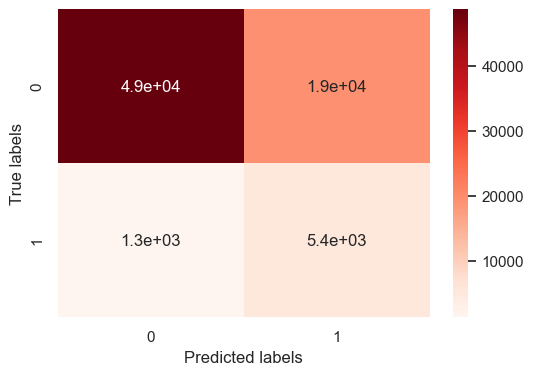

              precision    recall  f1-score   support

           0       0.97      0.72      0.82     68119
           1       0.22      0.81      0.34      6726

    accuracy                           0.72     74845
   macro avg       0.60      0.76      0.58     74845
weighted avg       0.91      0.72      0.78     74845

F1 score: 34.4%
Recall score: 80.9%
Precision score: 21.9%
Train Accuracy score: 72.6%
Test Accuracy score: 72.3%
The Parameters of this model are {'rf__bootstrap': False, 'rf__criterion': 'gini', 'rf__max_depth': 25, 'rf__min_samples_leaf': 15, 'rf__min_samples_split': 80, 'rf__n_estimators': 400}


In [190]:
# Calling the model eval function
model_eval(X_train, y_train, X_test, y_test, randund_random_forest_v3)

ROC AUC score: 0.8378130247020051


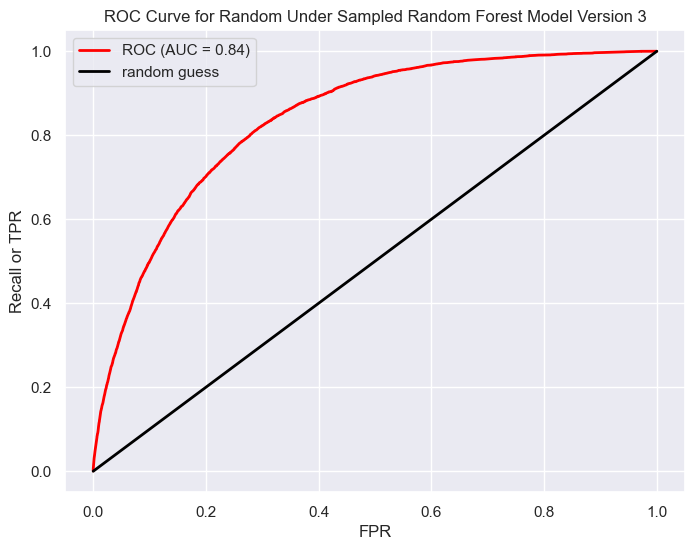

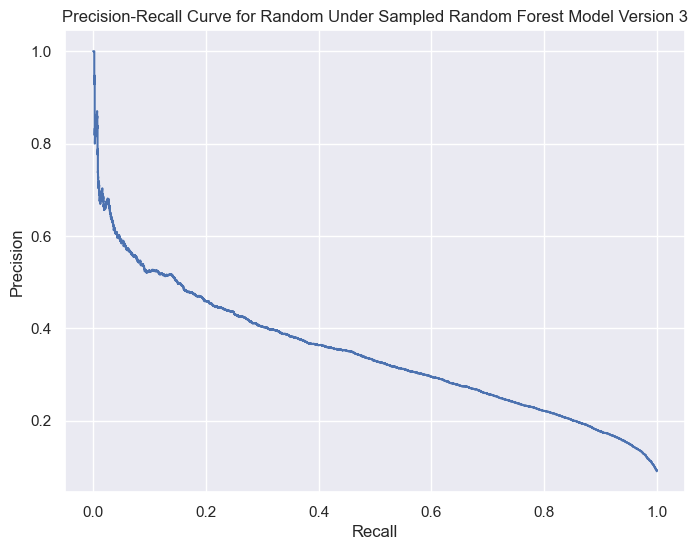

In [191]:
# Calling the ROC curve function
ROC_PR_Curve(X_test, y_test, randund_random_forest_v3, 'Random Under Sampled Random Forest Model Version 3')


### Random Forest Summary:

#### Confusion Matrix Discussion:

**RandOver version 2:**

[[48852 19267]

 [ 1321  5405]]

            precision   recall  f1-score   support

      0       0.97      0.72      0.83     68119
      1       0.22      0.80      0.34      6726


**RandUnder version 3:**

[[48711 19408]

 [ 1288  5438]]
      
            precision   recall  f1-score   support

      0       0.97      0.72      0.82     68119
      1       0.22      0.81      0.34      6726

RandomUnderSampling appears to be a more effective sampling technique for improving recall in a random forest model. Specifically, the recall for the positive class was found to be 1% higher compared to the v2 RandomOver sampled model. The improved recall seems to be due to an increase in the number of true positive predictions. However, it should be noted that the number of false positives has also increased, resulting in a decrease in true negative predictions.

#### Score Discussion:

RandomOverSampling v2:
- F1 score: 34.4%
- Recall score: 80.4%
- Precision score: 21.9%
- Train Accuracy score: 73.0%
- Test Accuracy score: 72.5%

RandomUnderSampling v3:
- F1 score: 34.4%
- Recall score: 80.9%
- Precision score: 21.9%
- Train Accuracy score: 72.6%
- Test Accuracy score: 72.3%

The RandomUnderSampled v3 model has outperformed the Undersampled model in recall by ~1%. Train and accuracy scores for both models are within +-0.4% of eachother. This suggests the models are not overfitted and generalise well to unseen data. The results from the RandomUnderSampled v3 model are the best yet. 

Both models have an AUC value of 0.84, this is very good. 

The precision recall curves are identical and show an improvement on the decision tree and logistic regression model curves. The sharp initial decent observed in the other curves is shallower in the random forest curves. The decrease as recall increases is also shallower than previous curves. 

### Feature Importance:

Now all random forest models have been run, I can extract feature importance of the best model. The scikit-learn logistic regression attribute `feature_importances_` will allow me to do this for each model. Im going to create a dataframe with the coefficients of each model as columns. GridSearch does not have a .coef_ attribute, I therefore need to access it by first returning the model object, with `.best_estimator_`, then the pipeline object with `named_steps` then the coefficients with `feature_importances_`.

In [192]:
# Extracting an array of feature importance for each final RF model
RF_randup_feature_importance = randup_rf_model_v2.best_estimator_.named_steps.rf.feature_importances_
RF_randund_feature_importance = randund_random_forest_v3.best_estimator_.named_steps.rf.feature_importances_

In [193]:
# Creating two dictionaries from the feature importance arrays

# Extracting the Keys for my dictionary
RF_feature_names = X_train.columns

# Creating the dictionaries
RF_feature_importances_randup_dict = dict(zip(RF_feature_names, RF_randup_feature_importance))
RF_feature_importances_randund_dict = dict(zip(RF_feature_names, RF_randund_feature_importance))



In [194]:
# Creating two dataframes from my dictionaries
rf_randup_df = pd.DataFrame.from_dict(RF_feature_importances_randup_dict, orient = 'index', columns = ['RF_randup_feature_importance'])
rf_randund_df = pd.DataFrame.from_dict(RF_feature_importances_randund_dict, orient = 'index', columns = ['RF_randund_feature_importance'])

In [195]:
# Concatenating the two dataframes
RF_feature_importance_df = pd.concat([rf_randup_df, rf_randund_df], axis = 1)
RF_feature_importance_df

,RF_randup_feature_importance,RF_randund_feature_importance
BMI,0.144195,0.029713
Smoking,0.023252,0.027026
AlcoholDrinking,0.006641,0.001721
Stroke,0.045747,0.066532
PhysicalHealth,0.060941,0.048095
MentalHealth,0.042410,0.014324
DiffWalking,0.057558,0.087327
Sex,0.039061,0.050316
AgeCategory,0.285579,0.390772
PhysicalActivity,0.013857,0.006885


In [196]:
# Setting the index name prior to resetting index
RF_feature_importance_df.index = RF_feature_importance_df.index.set_names(['Features'])
RF_feature_importance_df

,RF_randup_feature_importance,RF_randund_feature_importance
Features,,
BMI,0.144195,0.029713
Smoking,0.023252,0.027026
AlcoholDrinking,0.006641,0.001721
Stroke,0.045747,0.066532
PhysicalHealth,0.060941,0.048095
MentalHealth,0.042410,0.014324
DiffWalking,0.057558,0.087327
Sex,0.039061,0.050316
AgeCategory,0.285579,0.390772


In [197]:
# Resetting index
RF_feature_importance_df = RF_feature_importance_df.reset_index()

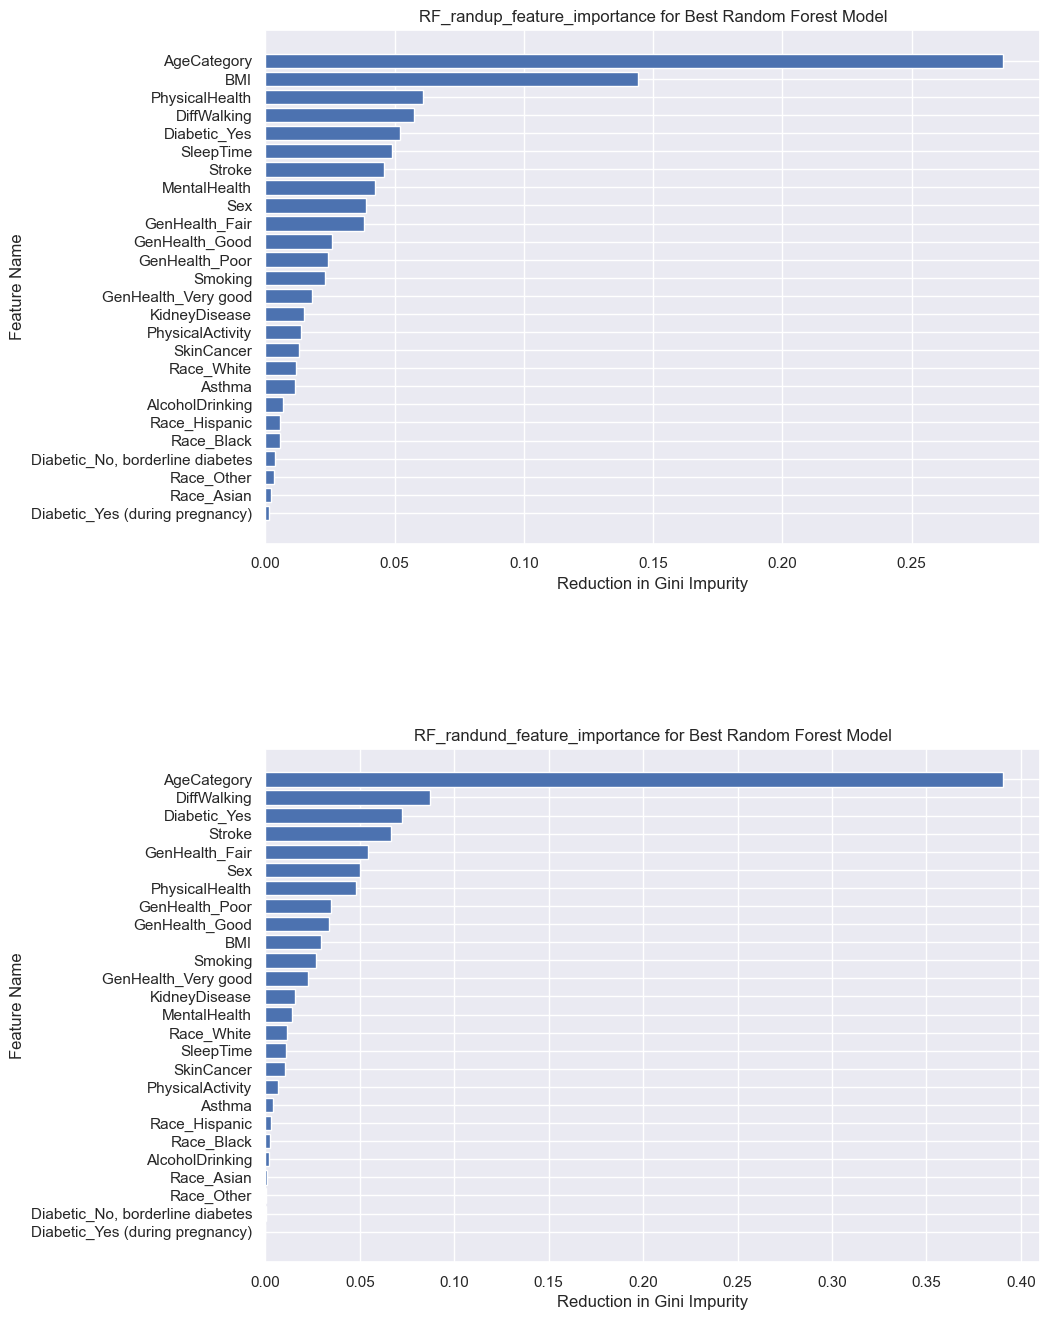

In [198]:
# Setting seaborn plot style and figure size
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(10,8*len(RF_feature_importance_df.columns[1:]))})

# Creating subplots based on number of features
f, axes = plt.subplots(len(RF_feature_importance_df.columns[1:]))
f.subplots_adjust(hspace=0.4)

# Looping through each feature and plotting its importance
for index, i in enumerate(RF_feature_importance_df.columns[1:]):
    RF_feature_importance_df = RF_feature_importance_df.sort_values(i, ascending=True)
    axes[index].barh(RF_feature_importance_df['Features'], RF_feature_importance_df[i])
    axes[index].set_xlabel('Reduction in Gini Impurity')
    axes[index].set_ylabel('Feature Name')
    axes[index].set_title(f'{i} for Best Random Forest Model')

# Displaying the plot
plt.show()


In [200]:
best_model = joblib.load('../models/random_forest_models/randund_version3_random_forest.pkl')

In [203]:
from sklearn.tree import export_graphviz

best_random_forest = best_model.best_estimator_.named_steps['rf']

# access the 5th tree in the forest
single_tree = best_random_forest.estimators_[4]

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,PhysicalActivity,...,Race_Hispanic,Race_Other,Race_White,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy)
0,16.60,1,0,0,3,30,0,0,57,1,...,0,0,1,0,0,0,1,0,1,0
1,20.34,0,0,1,0,0,0,0,80,1,...,0,0,1,0,0,0,1,0,0,0
2,26.58,1,0,0,20,30,0,1,67,1,...,0,0,1,1,0,0,0,0,1,0
3,24.21,0,0,0,0,0,0,0,77,0,...,0,0,1,0,1,0,0,0,0,0
4,23.71,0,0,0,28,0,1,0,42,1,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299374,27.41,1,0,0,7,0,1,1,62,0,...,1,0,0,1,0,0,0,0,1,0
299375,29.84,1,0,0,0,0,0,1,37,1,...,1,0,0,0,0,0,1,0,0,0
299376,24.24,0,0,0,0,0,0,0,47,1,...,1,0,0,0,1,0,0,0,0,0
299377,32.81,0,0,0,0,0,0,0,27,0,...,1,0,0,0,1,0,0,0,0,0


In [214]:
export_graphviz(single_tree, 
                out_file='tree.dot', 
                feature_names = X_train.columns,
                class_names = df.columns[0],
                rounded = True, proportion = False, 
                precision = 1, filled = True)

In [215]:
# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

-9

In [217]:
import os

os.system("dot -Tpng tree.dot -o tree.png")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.733518 to fit


0

![Alt text](../Visualisations/tree.png)

---

---

## 5. Closing Statement and Further Steps: 

#### Notes on the feature importance:

Both models have placed very similar importance on each feature. Its worth noting that the age category reduction in impurity is lower than that of the decision tree models. As such, all other features have slightly higher reduction in impurity. Following the hand in of this capstone project, I will select two models for the app - the version three random undersampled random forest model and the version two random undersampled logistic regression model. With the plan to create lifestyle improvement recommendations, the features of greatest importance that these recommendations can be applied to include BMI, Smoking, MentalHealth, SleepTime, Physical Activity, Alcohol drinking. 



This report explored the use of different sampling methods and machine learning models to predict the likelihood of cardiovascular disease (CVD). I've used logistic regression, decision tree, and random forest models with ADASYN, SMOTE, RandomOverSampling, and RandomUnderSampling methods. Results indicate that the random forest model with RandomUnderSampling was the most effective, achieving the highest recall and AUC score.

The purpose of these models is to create an app that can provide personalised feedback on lifestyle changes to reduce the risk of CVD. The app will calculate the best 'return on time investment' for each possible lifestyle change based on coefficients and gini impurity reductions from the models. The features that can be exploited to provide these recommendations, in order of importance, were BMI, Smoking, MentalHealth, SleepTime, Physical Activity, and Alcohol drinking. Finally, the coefficient values showed that BMI, Smoking, MentalHealth and physical activity had positive coefficients, while sleep time and alcohol consumption had negative coefficients.

Slightly more weighting will be applied to the mentalhealth category. There is an unmeasureable benefit (using my current model) that improving mental health will have towards all other lifestyle changes. 


#### Further Steps:

Im 99% sure that metrics like blood pressure, resting heart rate and cholesterol level are much better predictors of heart disease. To improve the current app concept, i'd like to include another model based on a dataset containing these granular stats. I placed alot of weight on model interpretability due to the need to find the key actionable indicators of CVD. In this new model, interpretability would not be required. As such, the full range of machine learning methods could be applied and an optimal model found.
This new model would become the soul predictor of heart disease in users and the CDC data trained model would be used purely for aiding in lifestyle change recommendations.

In addition to this, i'd like to retrain new models based on fresh lifestyle data from the CDC. I'd also like to use data with the original columns still available, having a dataset with pre engineered features limited the spectrum of potential lifestyle habits I could explore. For example, there were no features based on a users diet. 

Instead of talking about further iterations of the app, i'll try and describe a ideal final form for the app (As a commercial product). 

CardiApp: An app to take control of your heart health. 

In addition to the previously described features of the app e.g. % risk of CVD there will be:

1. A heart age calculation, this can also be calculated using the granular metrics heart disease data.

2. A thorough report based on user inputs of where they might direct their energy to see the greatest improvement in their heart health. This can be improved upon as more data is collected

3. A link with smart watches that gives up to date metrics on the users heart. 

4. A calorie, diet and nutrition tracker, this data can be used to iteratively train new models on the key indicators of heart disease.

5. A built in ECG analyser based on a CNN model. Smart watch technology is improving and implementing features ready for these advancements would be critical. There is a wealth of ECG data online that can be used to train a very reliable CNN model.

6. The ability for users to upload test results.

7. Integrate ChatGPT4 (or another LLM that is specialised to healthcare and medicine) into the app that can answer any questions a user may have and potentially explain test results if they are not clear. 